In [4]:
%cd /scratch_net/biwidl214/ecetin_scratch/GSCodec

/scratch_net/biwidl214/ecetin_scratch/GSCodec


/scratch_net/biwidl214/ecetin/conda_envs/gscodec/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
from submodules.gaussian_aggregation.jit_setup import setup as setup_gaussian_aggregation
from submodules.octree_generation.jit_setup import setup as setup_octree_generation
import torch
import os

setup_gaussian_aggregation()
setup_octree_generation()

Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module gaussian_aggregation, skipping build step...
Loading extension module gaussian_aggregation...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module octree_generation, skipping build step...
Loading extension module octree_generation...


In [14]:
from models.splatting.hierarchical_model.hierarchical_utils import generate_octree, assign_unique_values, aggregate_gaussians_recursively, calculate_weights
from models.splatting.hierarchical_model.hierarchical_gs import HierarchicalGSModel
from config.build_config_spaces import ConfigReader
from models.splatting.model_utils import concat_spherical_harmonics


reader = ConfigReader("config/preset_configs/hierarchical_gaussian.yaml")
dataset = reader.dataset_config
pipeline = reader.pipeline_config
optimization = reader.optimization_config
dataset.data_path = os.path.join(dataset.data_path, "tandt/train")

ckpt = torch.load("./output/hierarchical_full/train/checkpoints/ckpt_30000.pth")

gaussians = HierarchicalGSModel(dataset)
gaussians.restore_model(ckpt[0][:-1])

In [15]:
print(gaussians._xyz.shape)

torch.Size([692877, 3])


In [16]:
mu = gaussians.get_xyz.contiguous()
scale = gaussians.get_scaling.contiguous()
rotation = gaussians.get_rotation.contiguous()
# sigma = self.get_covariance().contiguous()
opacity = gaussians.get_opacity.contiguous()
sh = gaussians.get_features.contiguous()

weights = calculate_weights(gaussians.get_scaling, opacity).contiguous()

octree_max_depth = 20

# 3-sigma Gaussian ellipsoid surface approximation
gaussian_level_bboxes, gaussian_node_assignments, _ = generate_octree(points=gaussians.get_xyz, max_depth=octree_max_depth)

# Node ids were unique for the overall tensor, now we make them unique per depth level
# gaussian_node_assignments = assign_unique_values(gaussian_node_assignments)
unique_per_col_gaussian_node_assignments = assign_unique_values(
    gaussian_node_assignments
).contiguous()

## Analyzing # of points at each depth level

In [17]:
num_gaussians = []
for depth in range(1, 21):
    (
        current_mu,
        current_scales,
        current_rotations,
        current_opacity,
        current_sh,
    ) = aggregate_gaussians_recursively(
        weights,
        mu,
        scale,
        rotation,
        opacity,
        sh,
        unique_per_col_gaussian_node_assignments,
        depth,
        octree_max_depth,
        return_all_levels=False,
    )
    num_gaussians.append(current_mu.shape[0])

ratios = [after/pre for pre, after in zip(num_gaussians[:19], num_gaussians[1:20])]

In [18]:
num_gaussians[14], num_gaussians[15], num_gaussians[16], num_gaussians[17]

(678481, 688609, 691932, 692710)

In [19]:
# psnrs = [23.845347769222908,
#         24.98388930965415,
#         25.538065560653934,
#         25.843751105467092,
#         26.048170194789456,
#         26.255407060550805,
#         26.48787812942161,
#         26.832702143823653,
#         27.25817363517896]

# psnrs = [
#     21.176158659832257,
#     21.991785249341042,
#     22.165363863354756,
#     22.25281360858491,
#     22.332320301149707,
#     22.420736442921037,
#     22.506154573811905,
#     22.58640816546679,
#     22.64441684843615
# ]

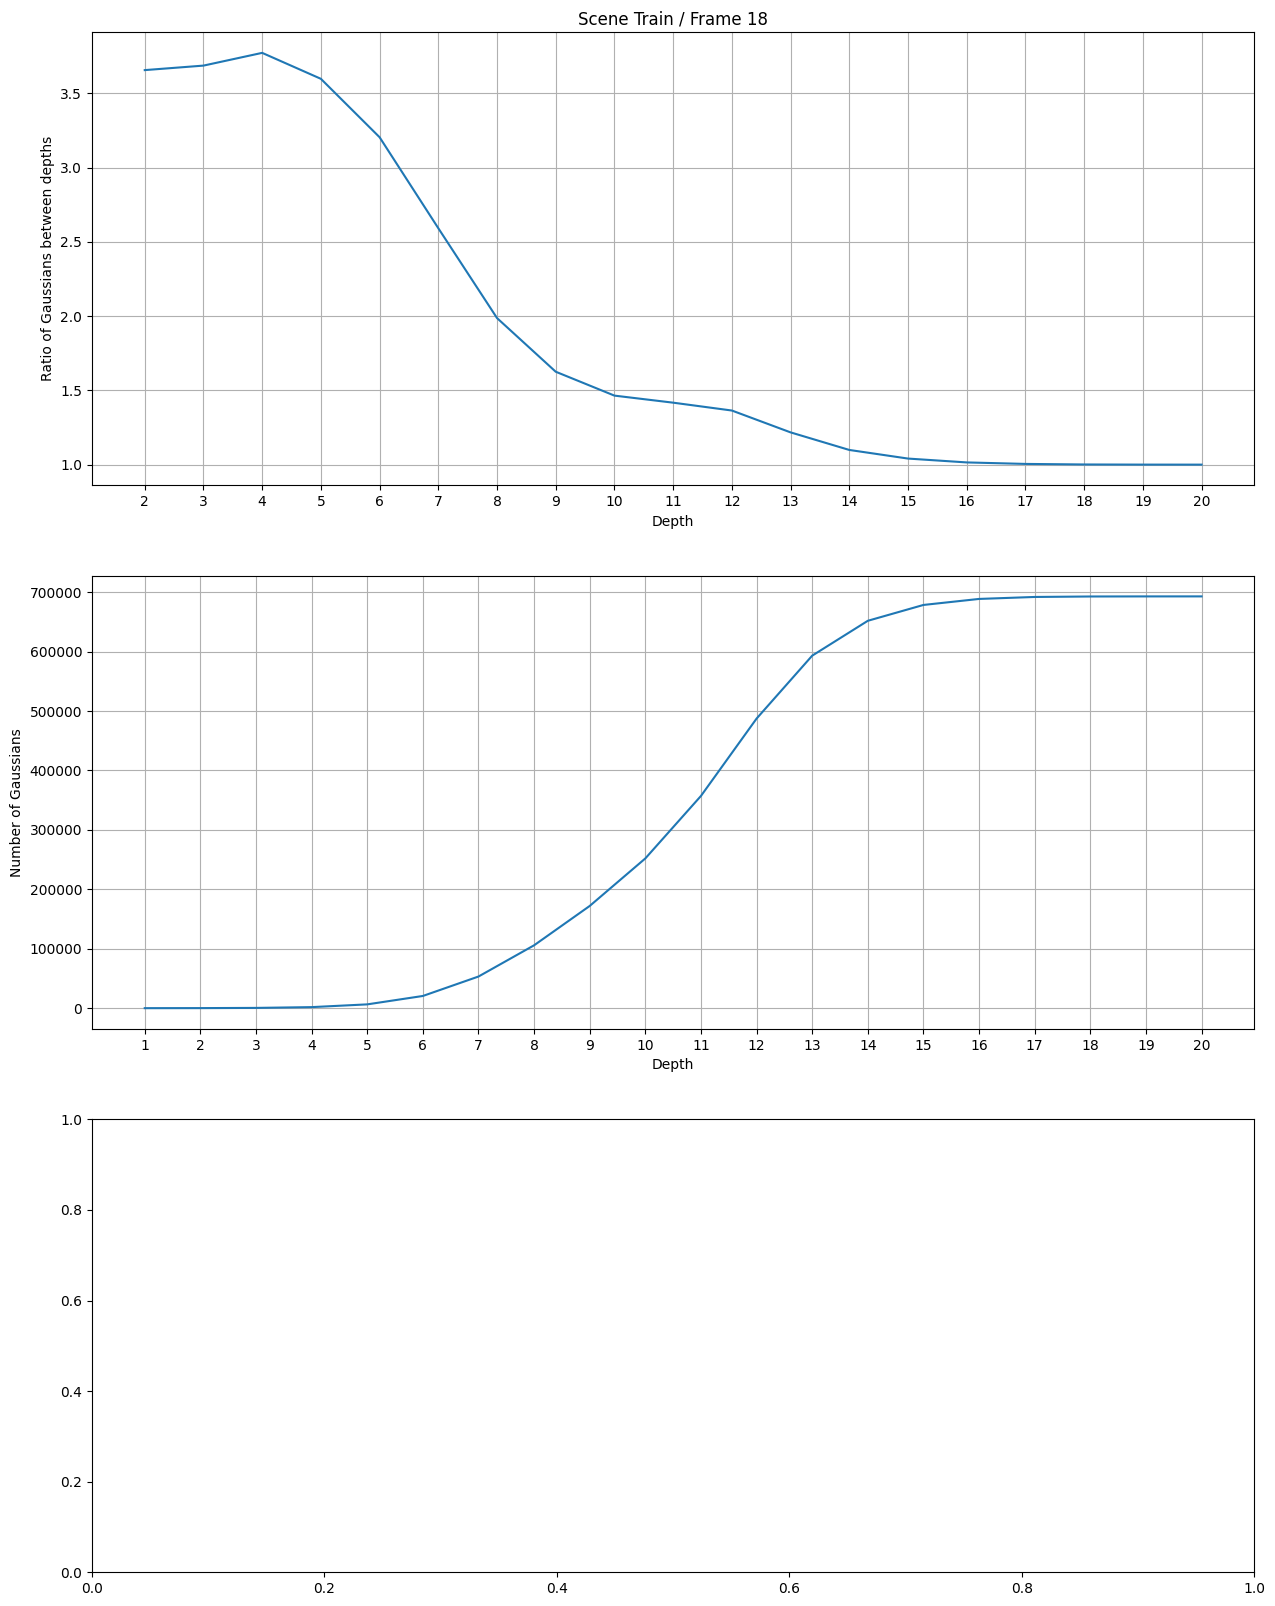

In [20]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

ax1.set_title("Scene Train / Frame 18")
ax1.plot(range(2, 21), ratios)
ax1.grid()
ax1.set_ylabel("Ratio of Gaussians between depths")
ax1.set_xlabel("Depth")
ax1.set_xticks(range(2, 21))

ax2.plot(range(1, 21), num_gaussians)
ax2.set_ylabel("Number of Gaussians")
ax2.set_xlabel("Depth")
ax2.set_xticks(range(1, 21))
ax2.grid()

# ax3.plot(range(12, 21), psnrs)
# # Assuming ax3 is your matplotlib.axes._axes.Axes object
# ax3.axhline(y=psnrs[-1], color='red', linestyle='--')

# ax3.set_ylabel("PSNR")
# ax3.set_xlabel("Depth")
# ax3.set_xlim(2, 21)
# ax3.set_xticks(range(1, 21))
# ax3.grid()


## Analyzing similarity of Gaussians in same bounding box

In [21]:
depth = 13
unique_per_col_gaussian_node_assignments[:, depth]

tensor([406810, 272735, 115653,  ...,  71645,  58474, 573545], device='cuda:0')

In [22]:
uniques, counts = unique_per_col_gaussian_node_assignments[:, depth].unique(return_counts=True)

idx = counts.argmax()
max_id = uniques[idx]
print(counts.max())

max_id

tensor(42, device='cuda:0')


tensor(460345, device='cuda:0')

In [23]:
def cosine_similarity(q1, q2):
    dot_product = torch.sum(q1 * q2, dim=-1)
    return dot_product

def l2_similarity(q1, q2):
    return torch.norm(q1 - q2, dim=-1)

def distance_to_similarity(distance, alpha=1.0):
    return torch.exp(-alpha * distance)

# Normalize the scales
def normalize_scales(scales):
    norms = torch.norm(scales, dim=1, keepdim=True)
    return scales / norms

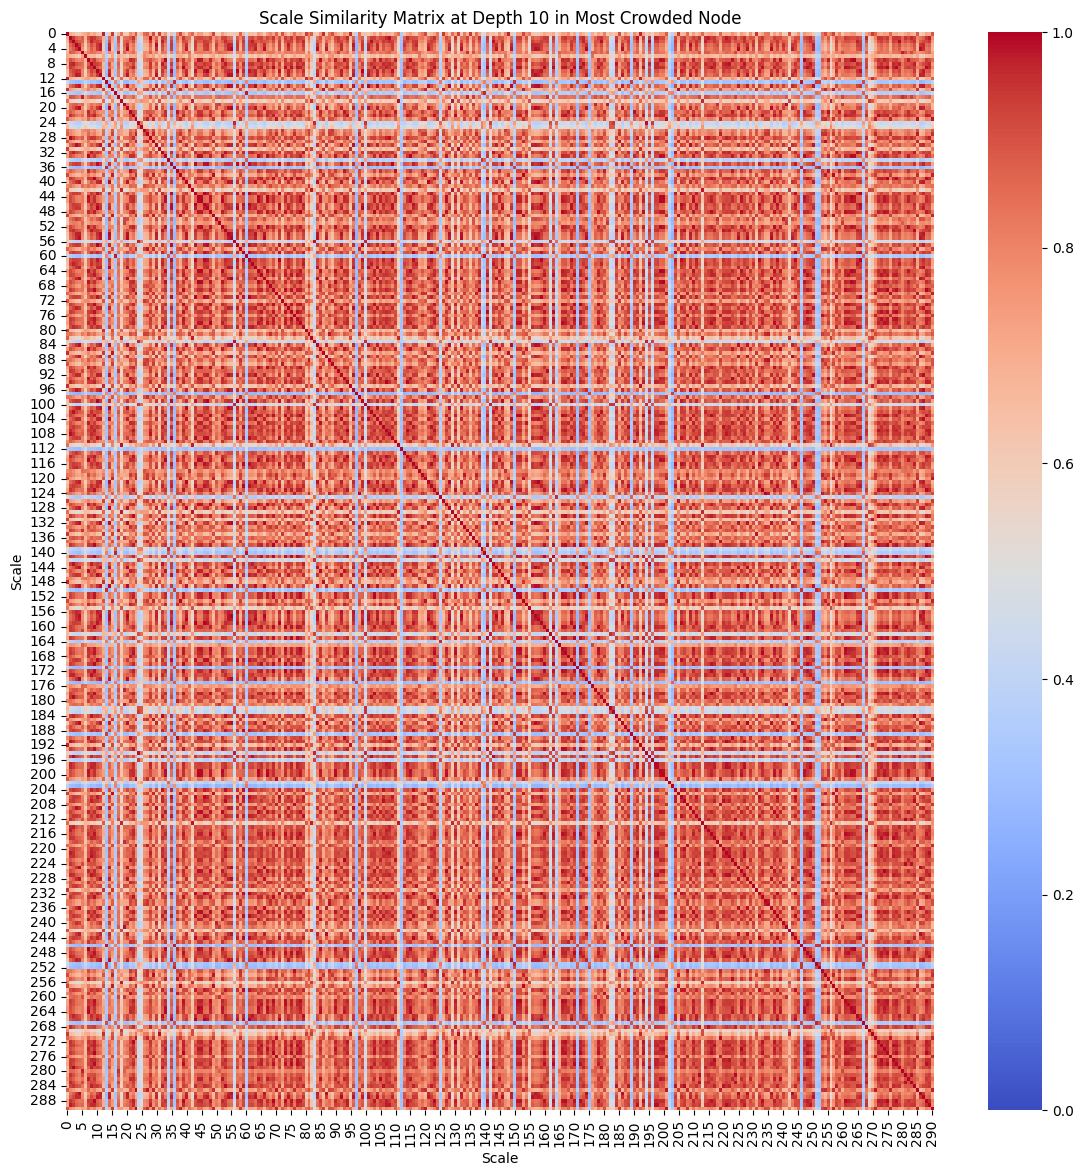

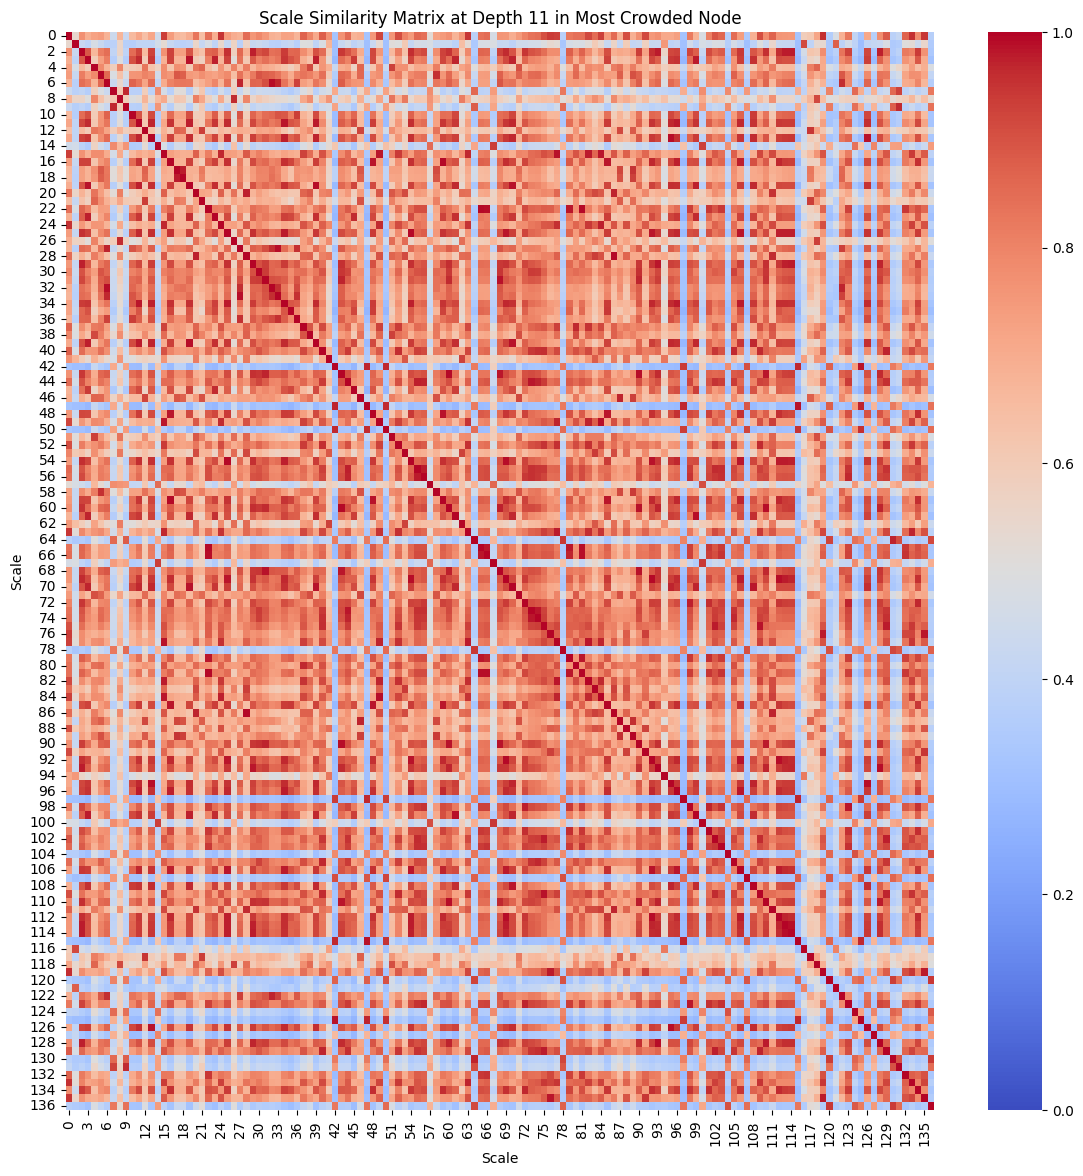

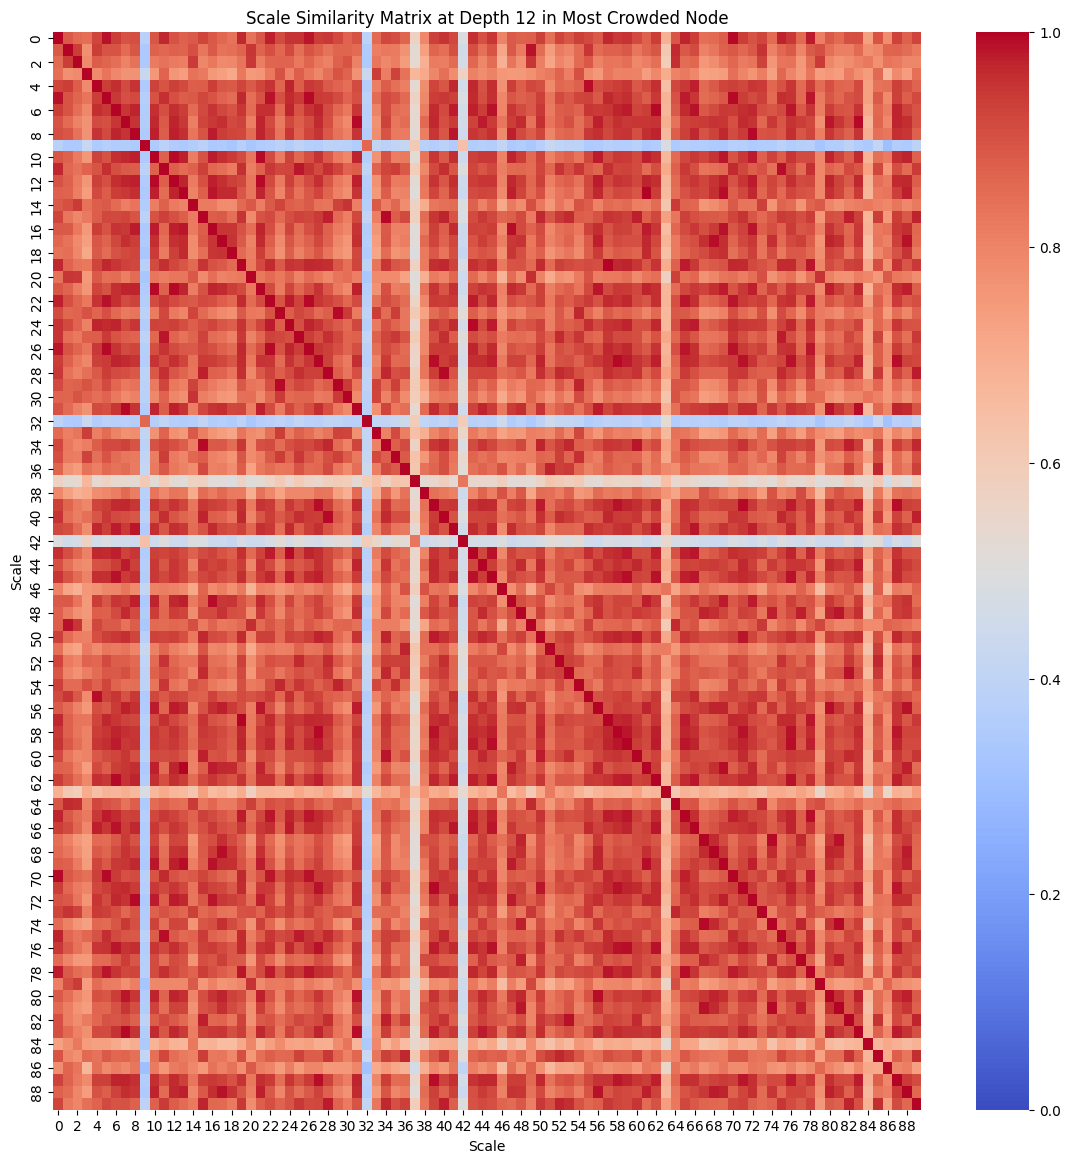

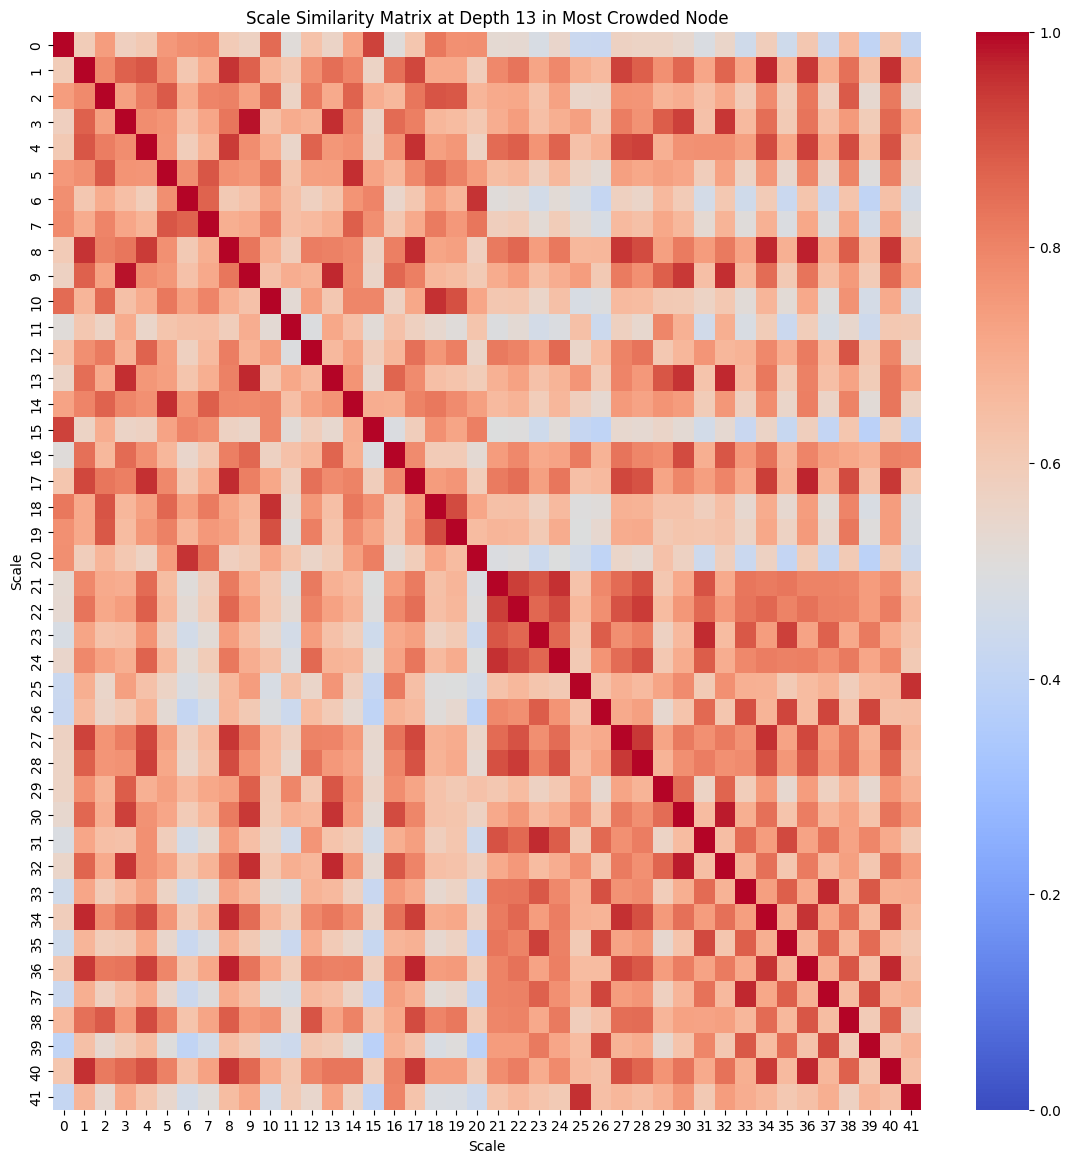

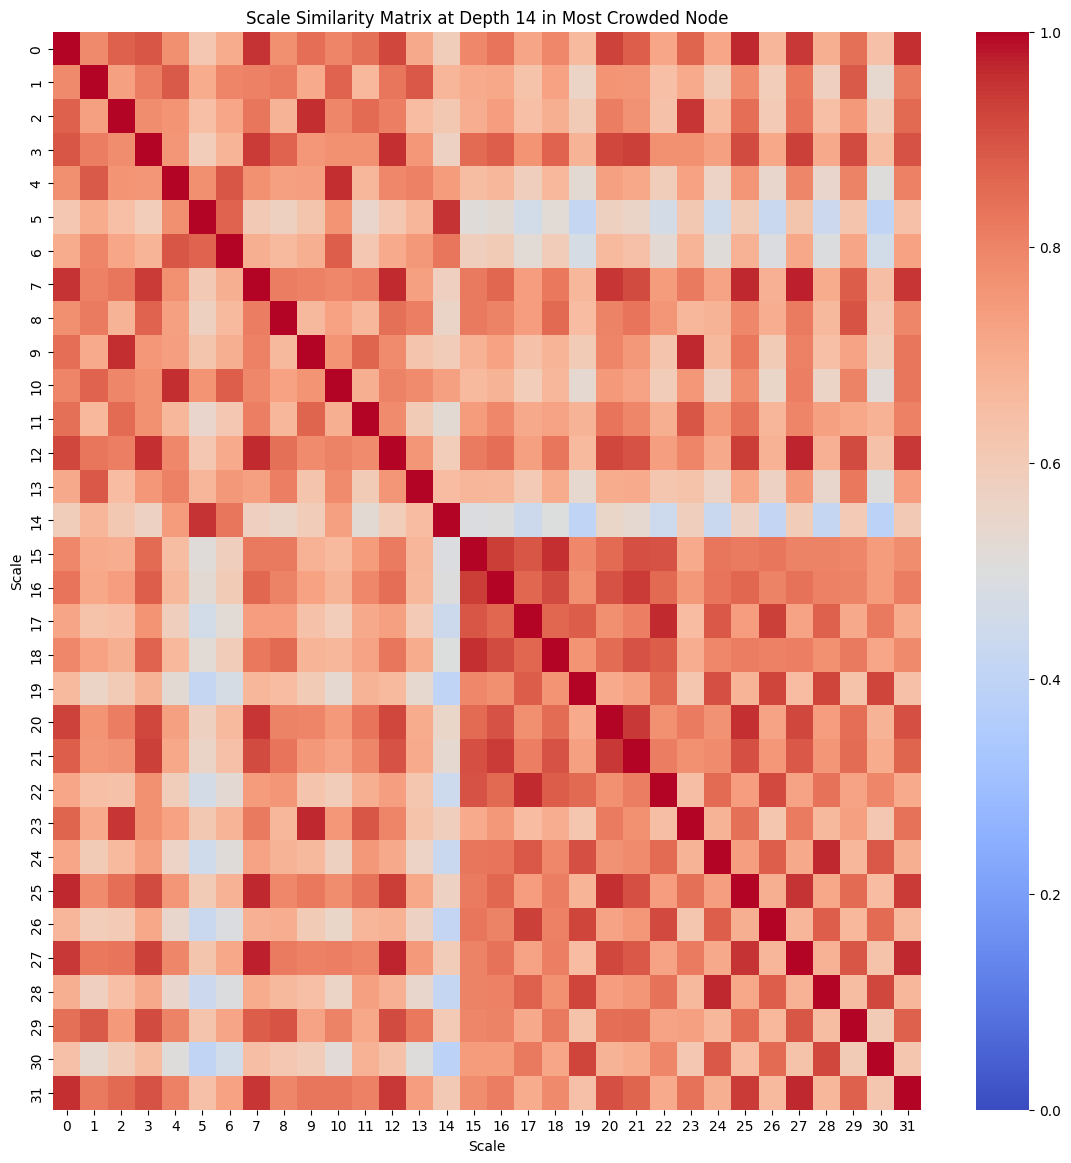

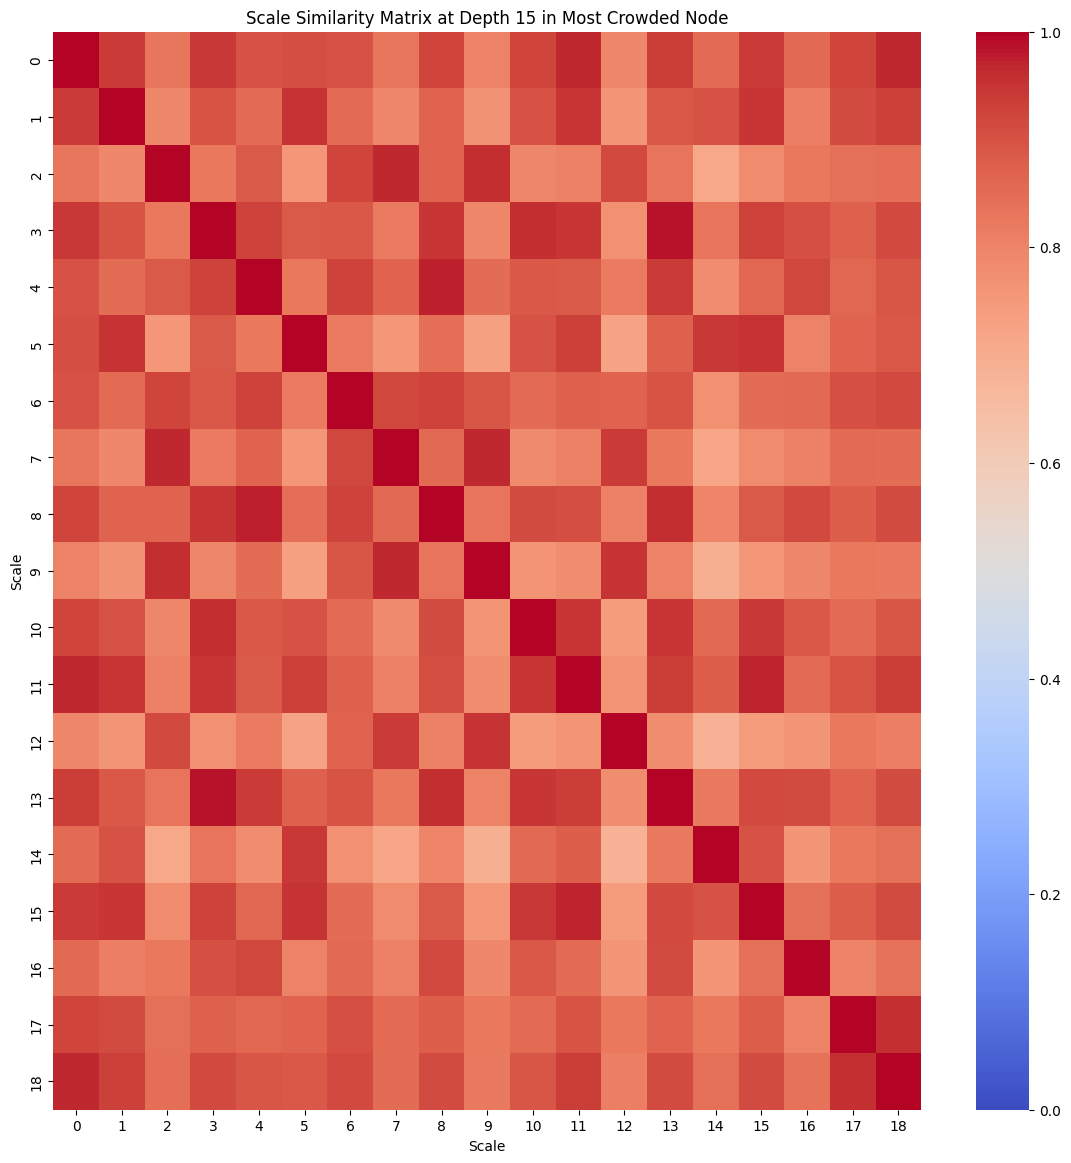

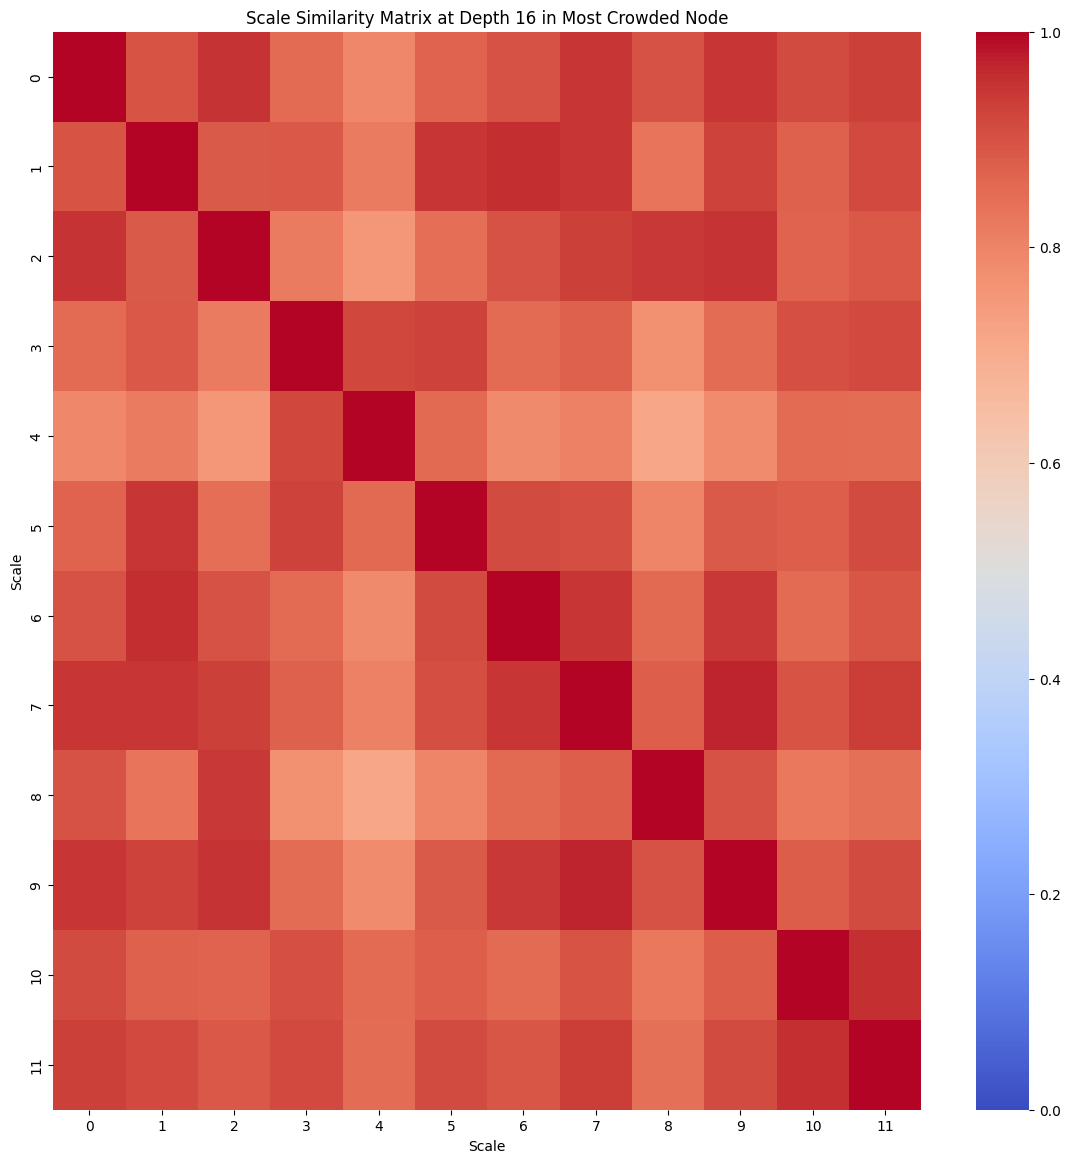

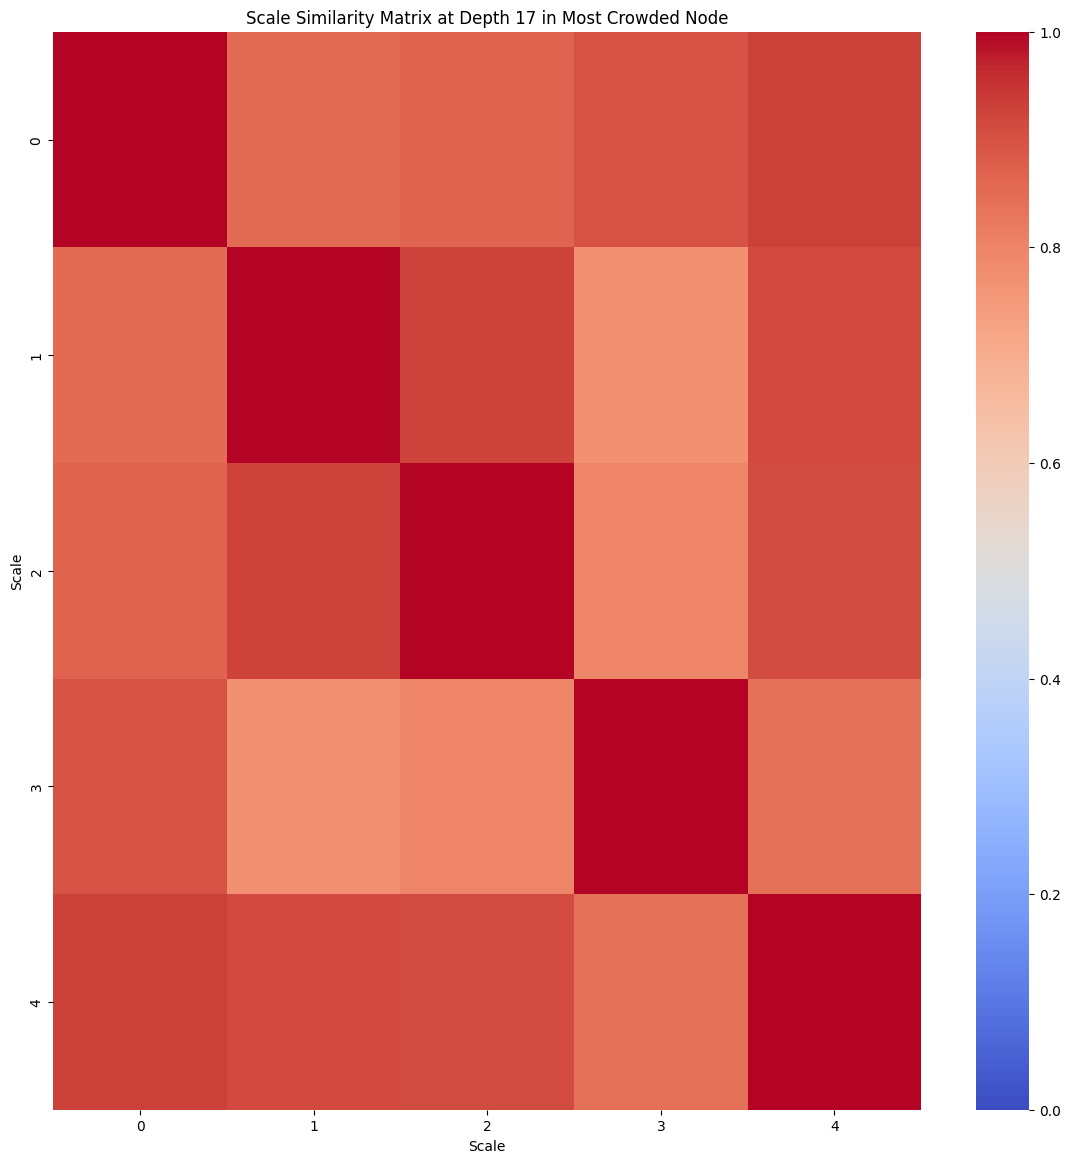

In [24]:
import seaborn as sns


for depth in range(10, 18):
    uniques, counts = unique_per_col_gaussian_node_assignments[:, depth].unique(return_counts=True)

    sorted_count, idxs = torch.sort(counts, descending=True)
    max_id = uniques[idxs[0]]

    # quaternions = gaussians.get_rotation[unique_per_col_gaussian_node_assignments[:, depth] == max_id]
    # compression_target = quaternions
    scales = normalize_scales(gaussians.get_scaling[unique_per_col_gaussian_node_assignments[:, depth] == max_id])
    compression_target = scales
    # shs = concat_spherical_harmonics(
    #     gaussians._features_dc[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
    #     gaussians._features_rest[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
    #     permute=False
    # )
    # compression_target = normalize_scales(shs)

    # Compare each quaternion with every other quaternion
    N = compression_target.shape[0]
    similarity_matrix = torch.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            similarity_matrix[i, j] = distance_to_similarity(
                l2_similarity(
                    compression_target[i], compression_target[j])
            ).detach().cpu()
            # similarity_matrix[i, j] = cosine_similarity(
            #         compression_target[i], compression_target[j]).detach().cpu()
            similarity_matrix[j, i] = similarity_matrix[i, j]

    # Define a similarity threshold
    threshold = 0.95
    similarity_matrix_bool = similarity_matrix >= threshold

    # Visualization
    plt.figure(figsize=(14, 14))
    sns.heatmap(
        similarity_matrix.numpy(), annot=False, cmap='coolwarm', cbar=True, 
        vmin=0, vmax=1,  # Fixed color map range
        # xticklabels=[f'Q{i+1}' for i in range(N)], 
        # yticklabels=[f'Q{i+1}' for i in range(N)]
    )
    plt.title(f'Scale Similarity Matrix at Depth {depth} in Most Crowded Node')
    plt.xlabel('Scale')
    plt.ylabel('Scale')
    plt.show()

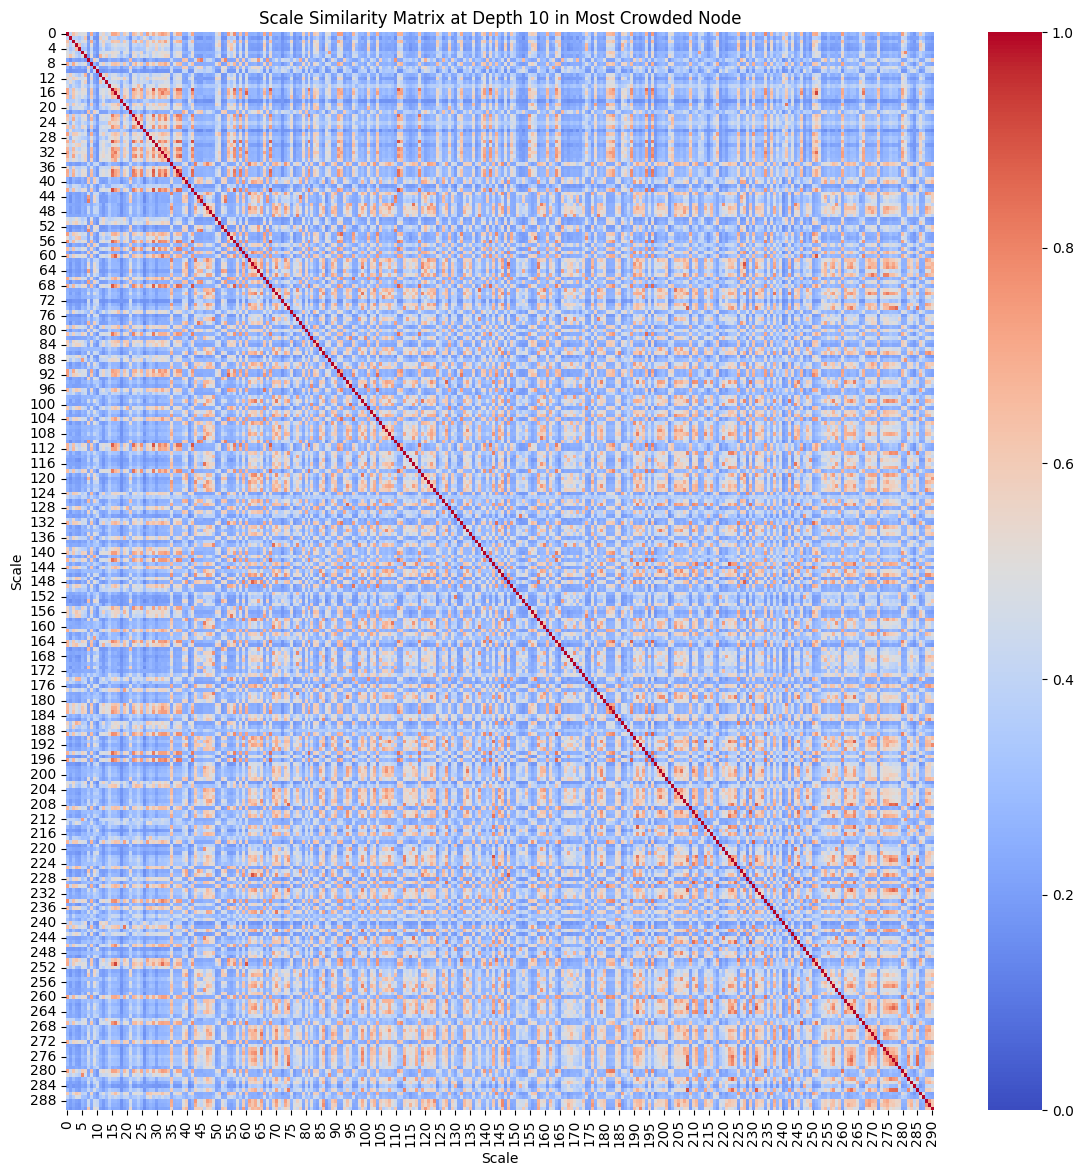

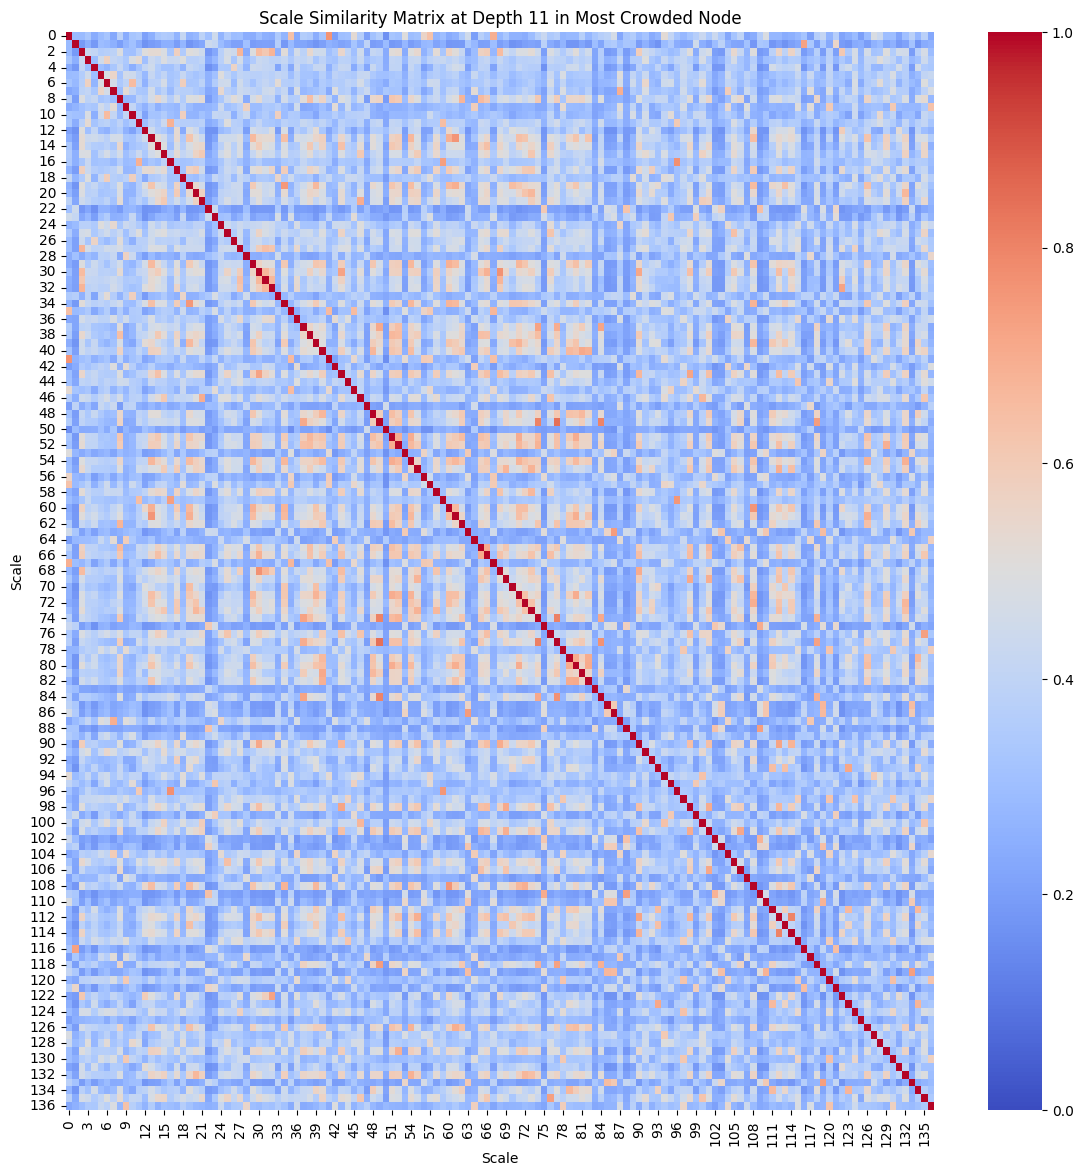

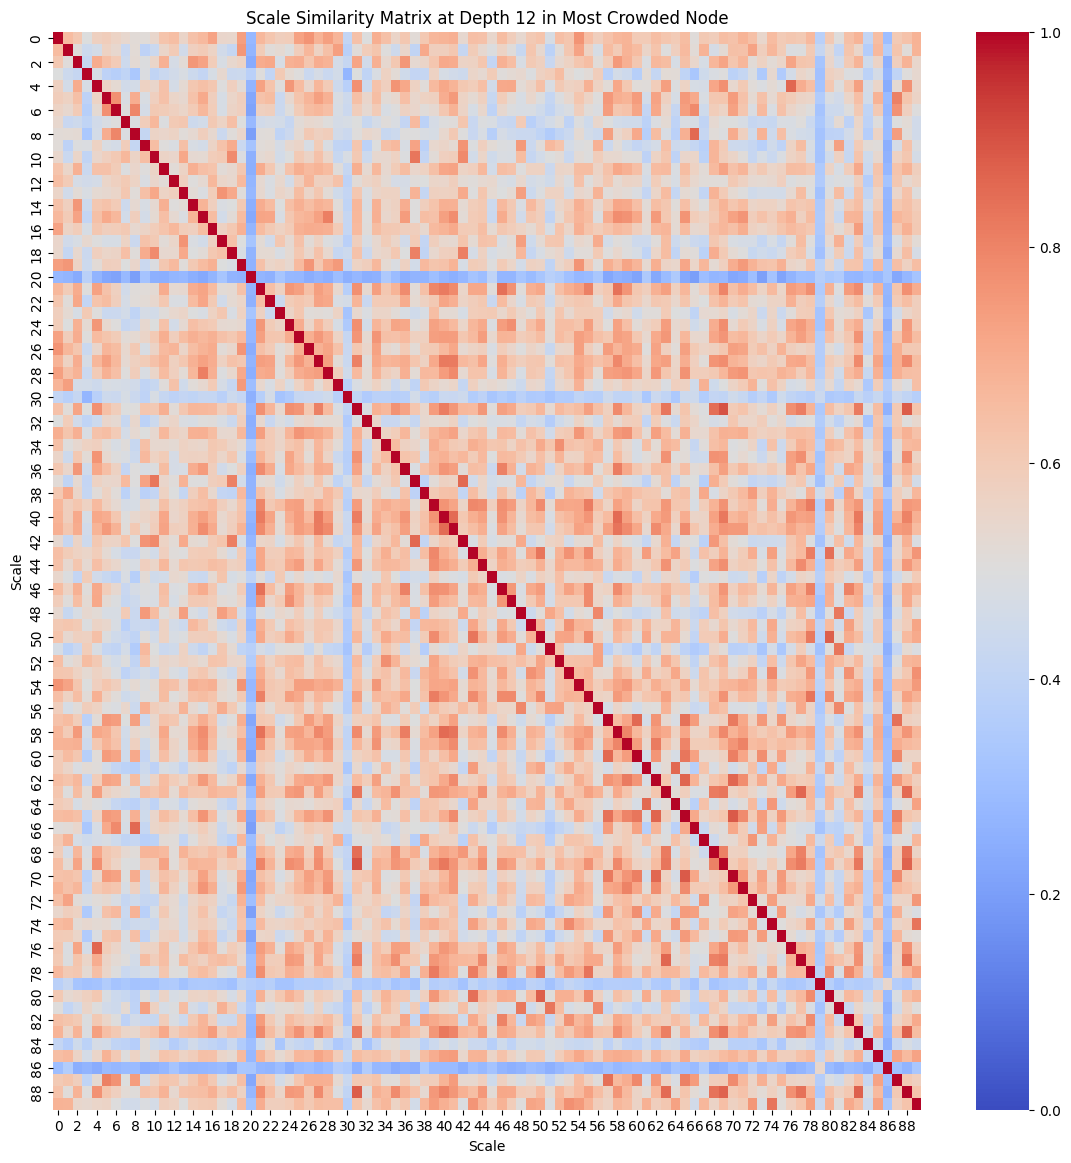

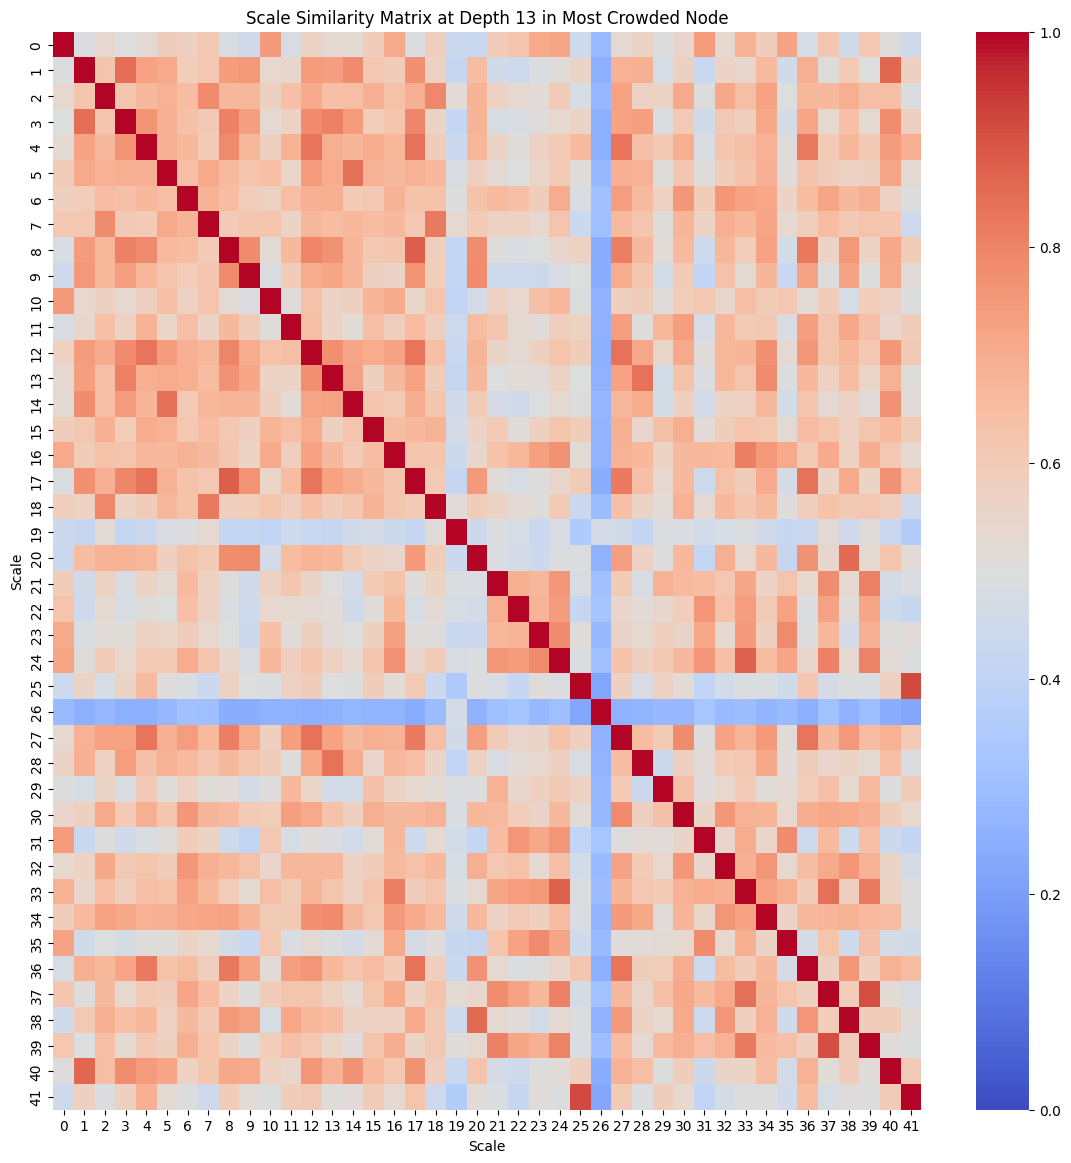

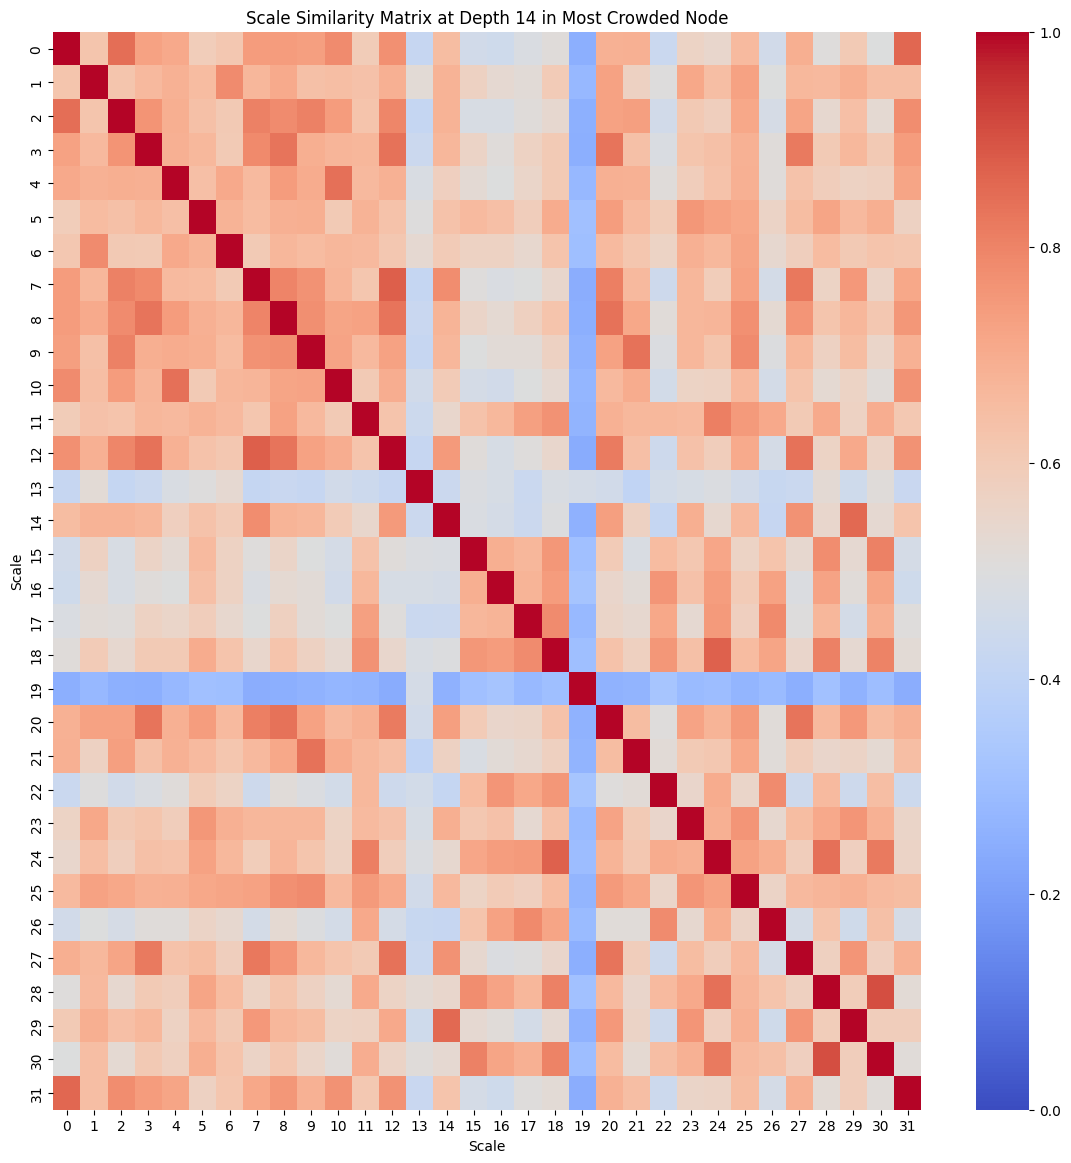

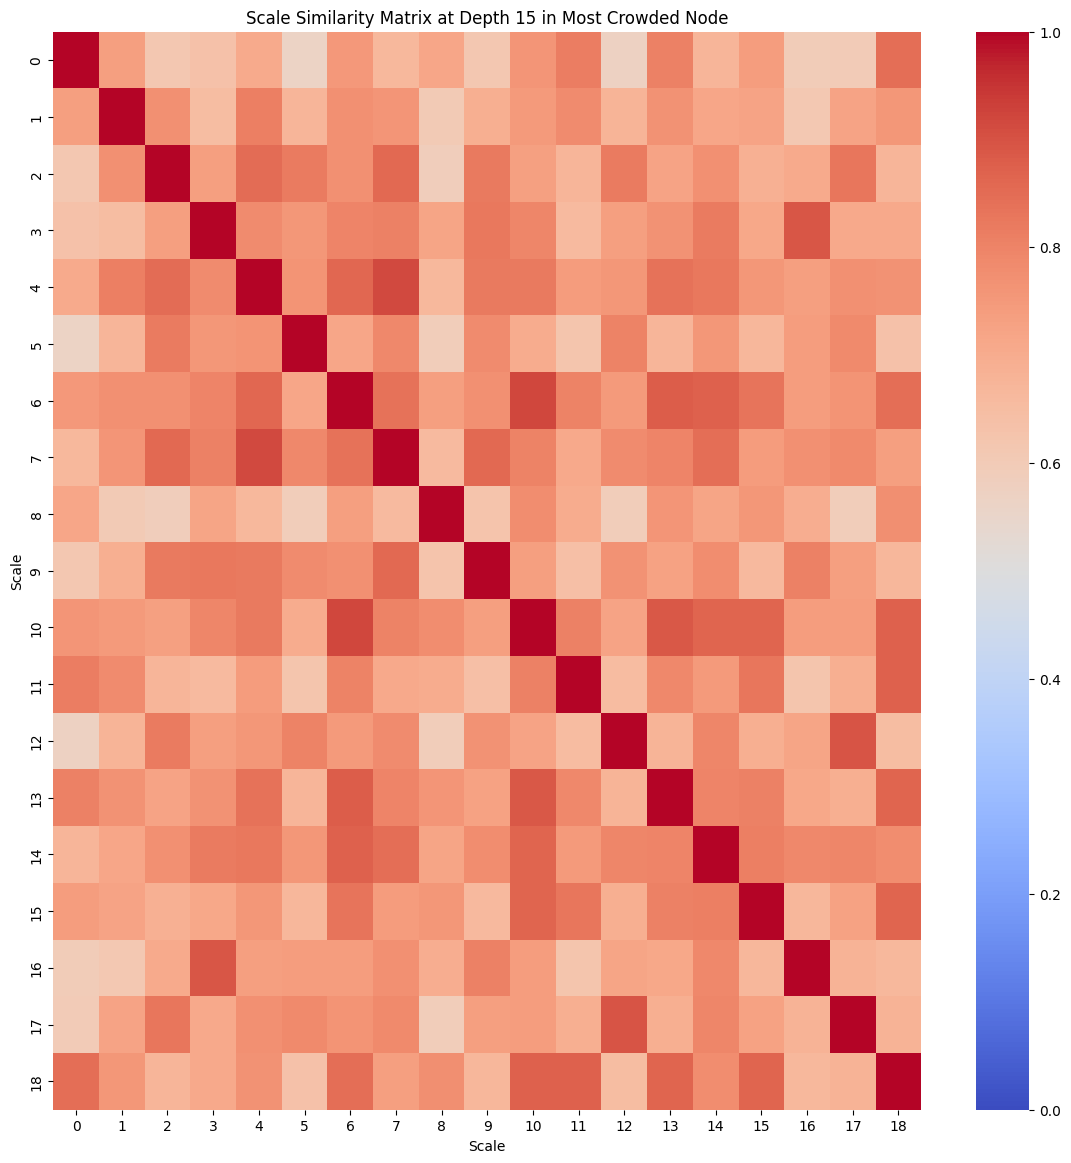

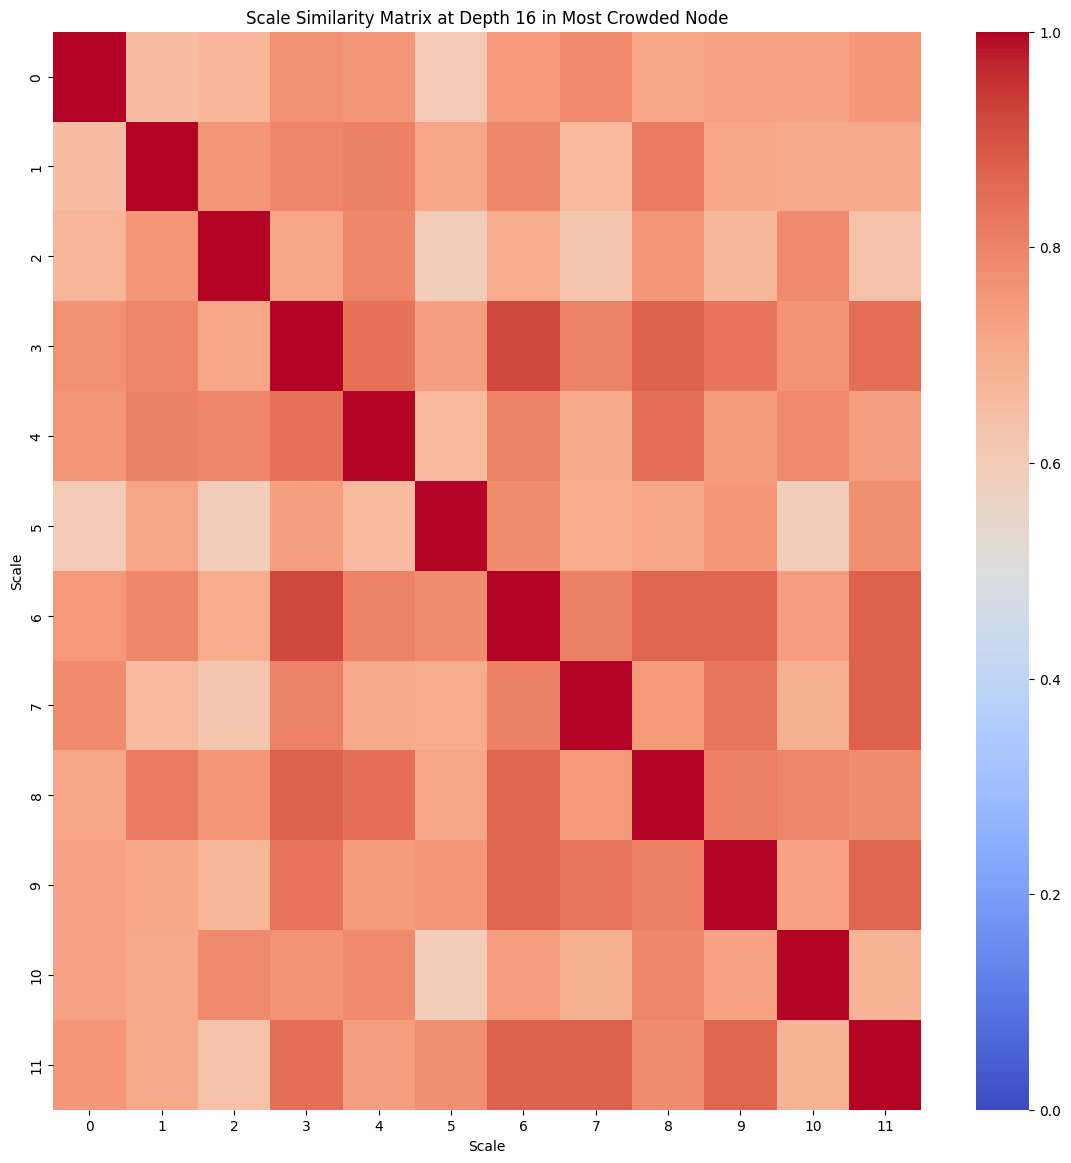

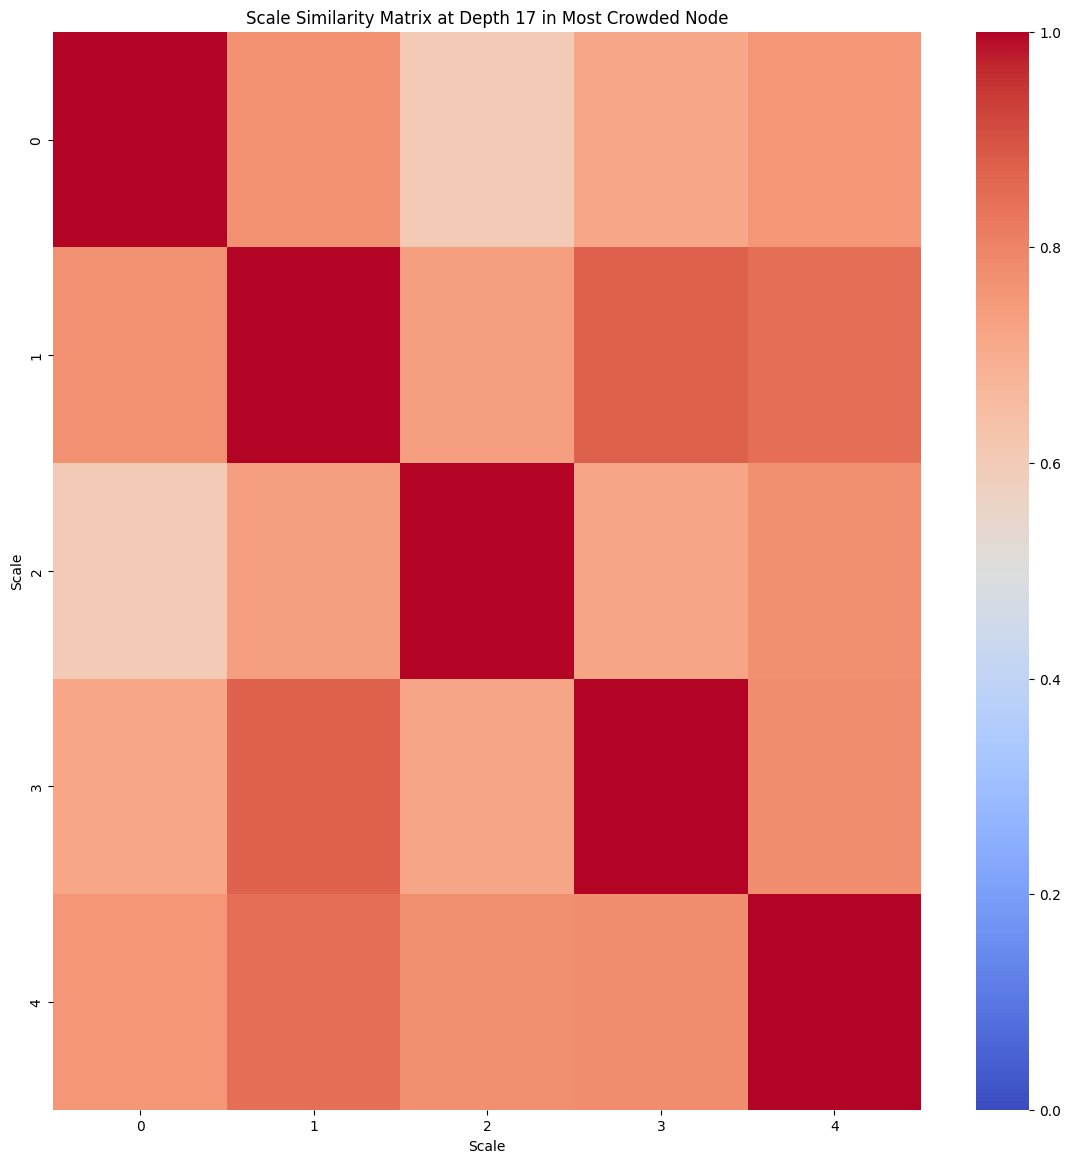

In [27]:
import seaborn as sns


for depth in range(10, 18):
    uniques, counts = unique_per_col_gaussian_node_assignments[:, depth].unique(return_counts=True)

    sorted_count, idxs = torch.sort(counts, descending=True)
    max_id = uniques[idxs[0]]

    # quaternions = gaussians.get_rotation[unique_per_col_gaussian_node_assignments[:, depth] == max_id]
    # compression_target = quaternions
    # scales = normalize_scales(gaussians.get_scaling[unique_per_col_gaussian_node_assignments[:, depth] == max_id])
    # compression_target = scales
    shs = concat_spherical_harmonics(
        gaussians._features_dc[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
        gaussians._features_rest[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
        permute=False
    )
    compression_target = normalize_scales(shs)

    # Compare each quaternion with every other quaternion
    N = compression_target.shape[0]
    similarity_matrix = torch.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            similarity_matrix[i, j] = distance_to_similarity(
                l2_similarity(
                    compression_target[i], compression_target[j])
            ).detach().cpu()
            # similarity_matrix[i, j] = cosine_similarity(
            #         compression_target[i], compression_target[j]).detach().cpu()
            similarity_matrix[j, i] = similarity_matrix[i, j]

    # Define a similarity threshold
    threshold = 0.95
    similarity_matrix_bool = similarity_matrix >= threshold

    # Visualization
    plt.figure(figsize=(14, 14))
    sns.heatmap(
        similarity_matrix.numpy(), annot=False, cmap='coolwarm', cbar=True, 
        vmin=0, vmax=1,  # Fixed color map range
        # xticklabels=[f'Q{i+1}' for i in range(N)], 
        # yticklabels=[f'Q{i+1}' for i in range(N)]
    )
    plt.title(f'Scale Similarity Matrix at Depth {depth} in Most Crowded Node')
    plt.xlabel('Scale')
    plt.ylabel('Scale')
    plt.show()

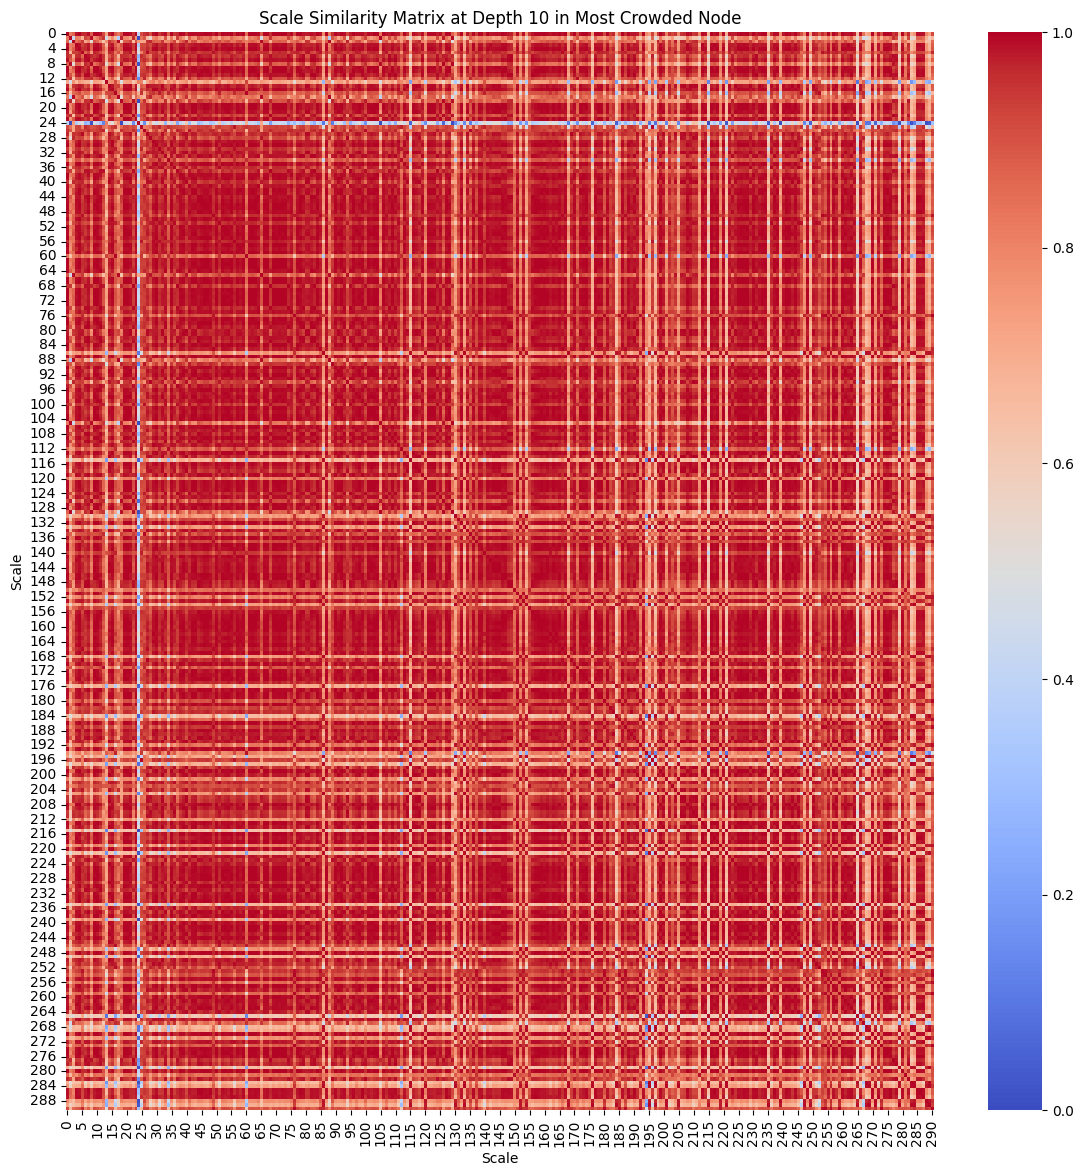

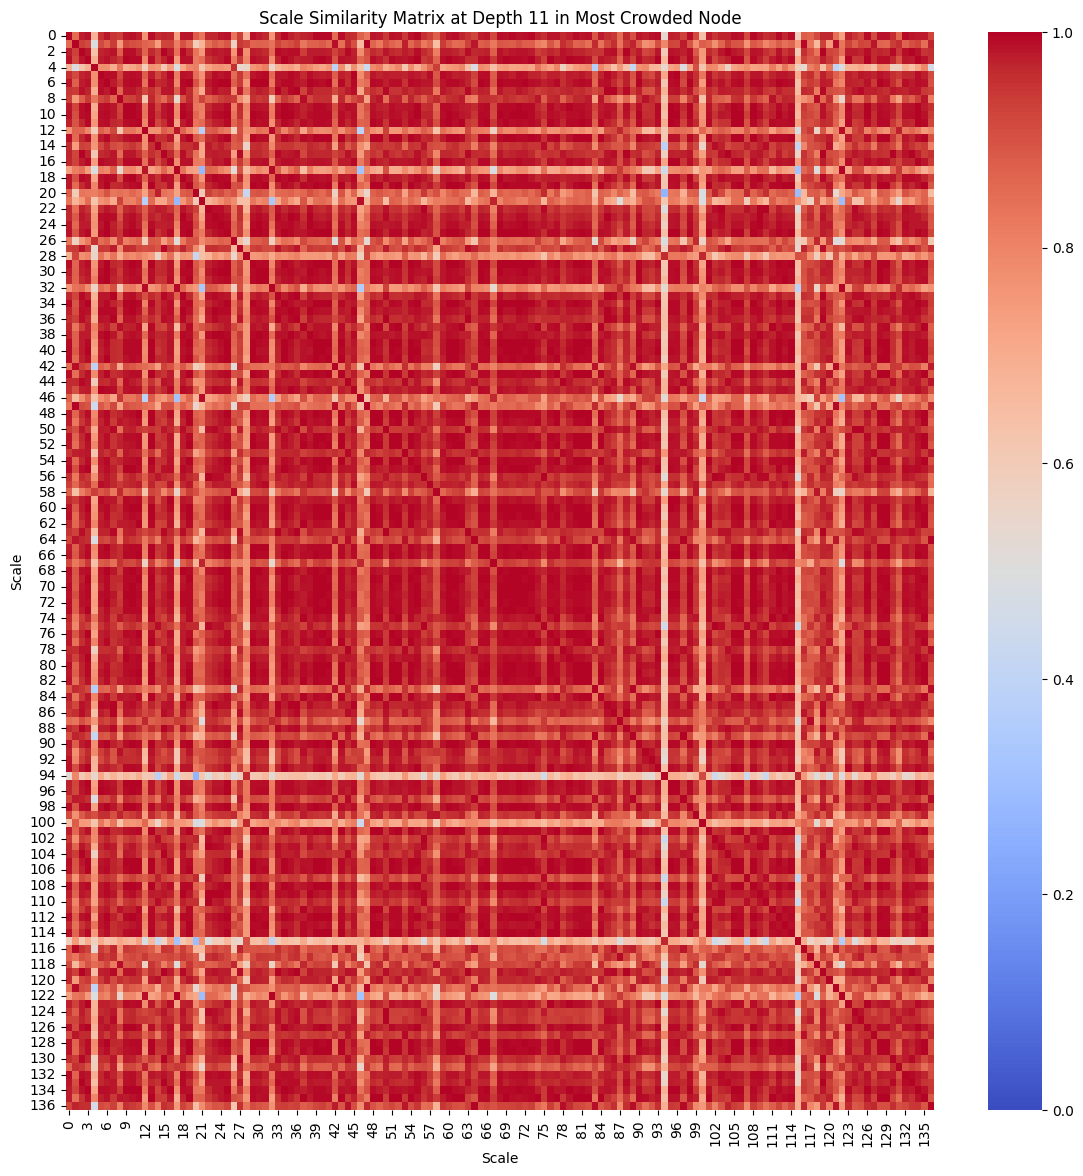

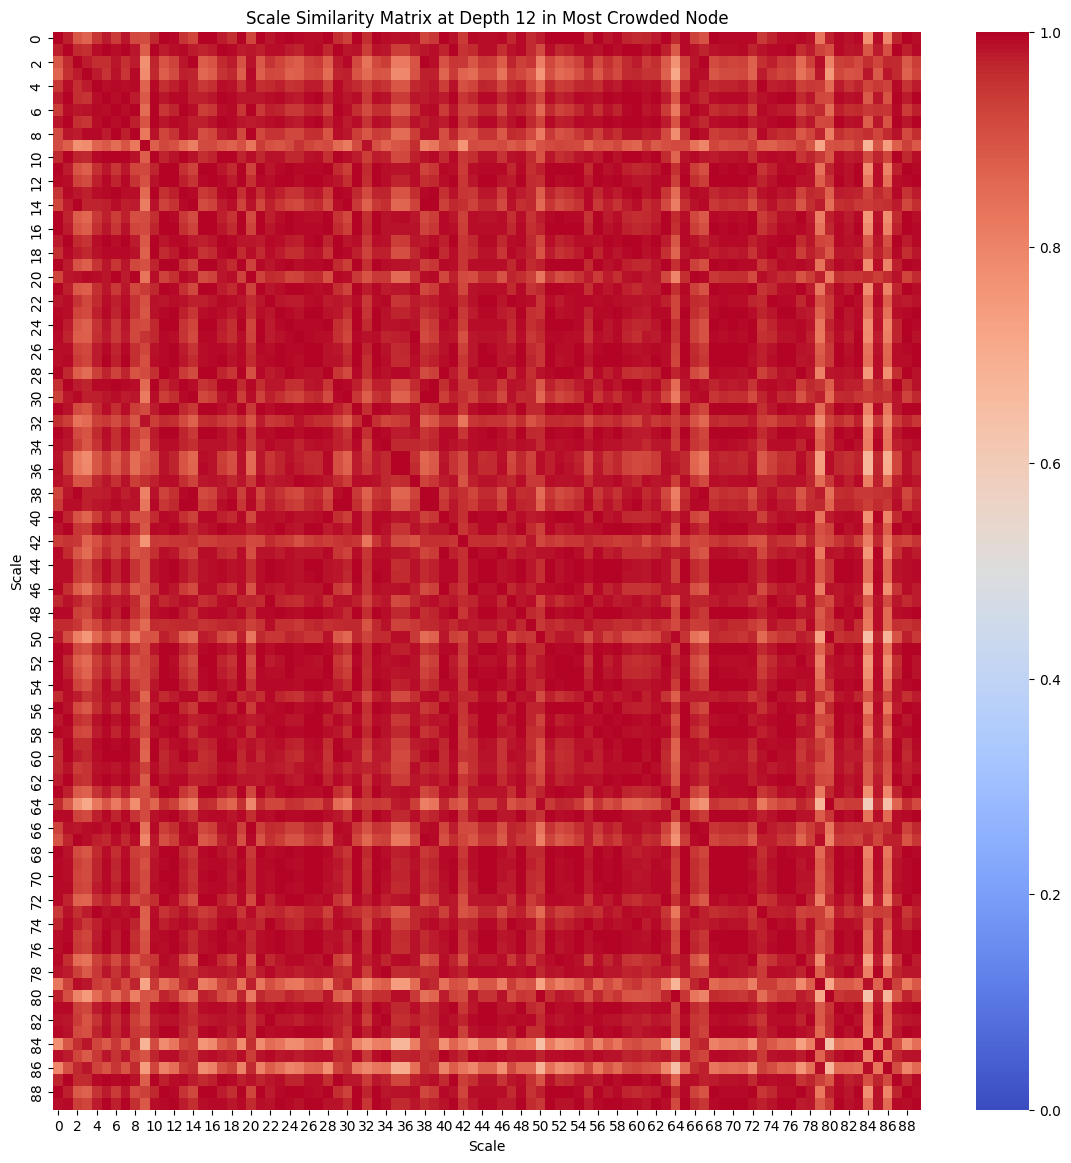

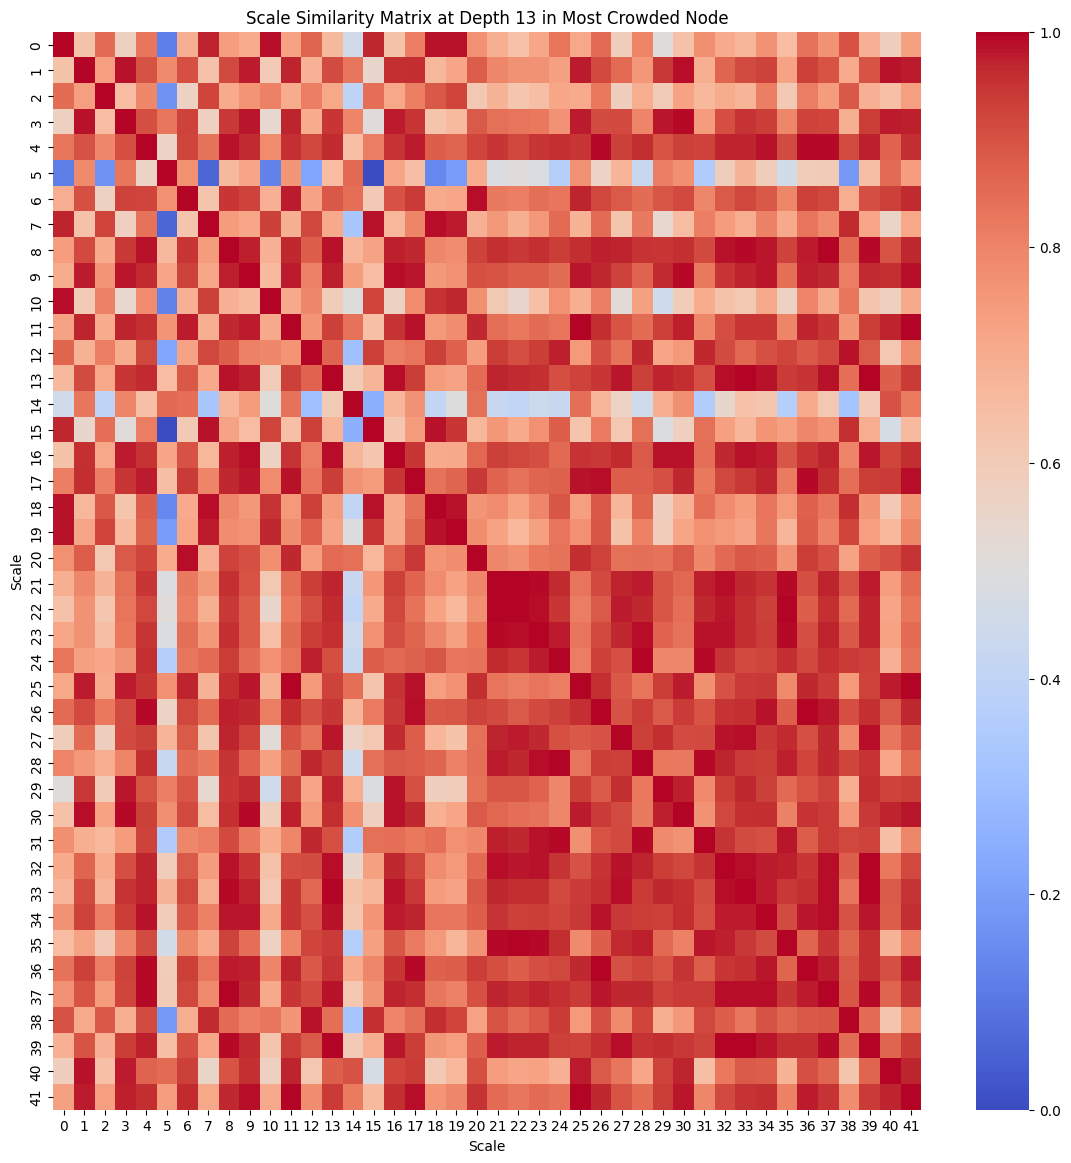

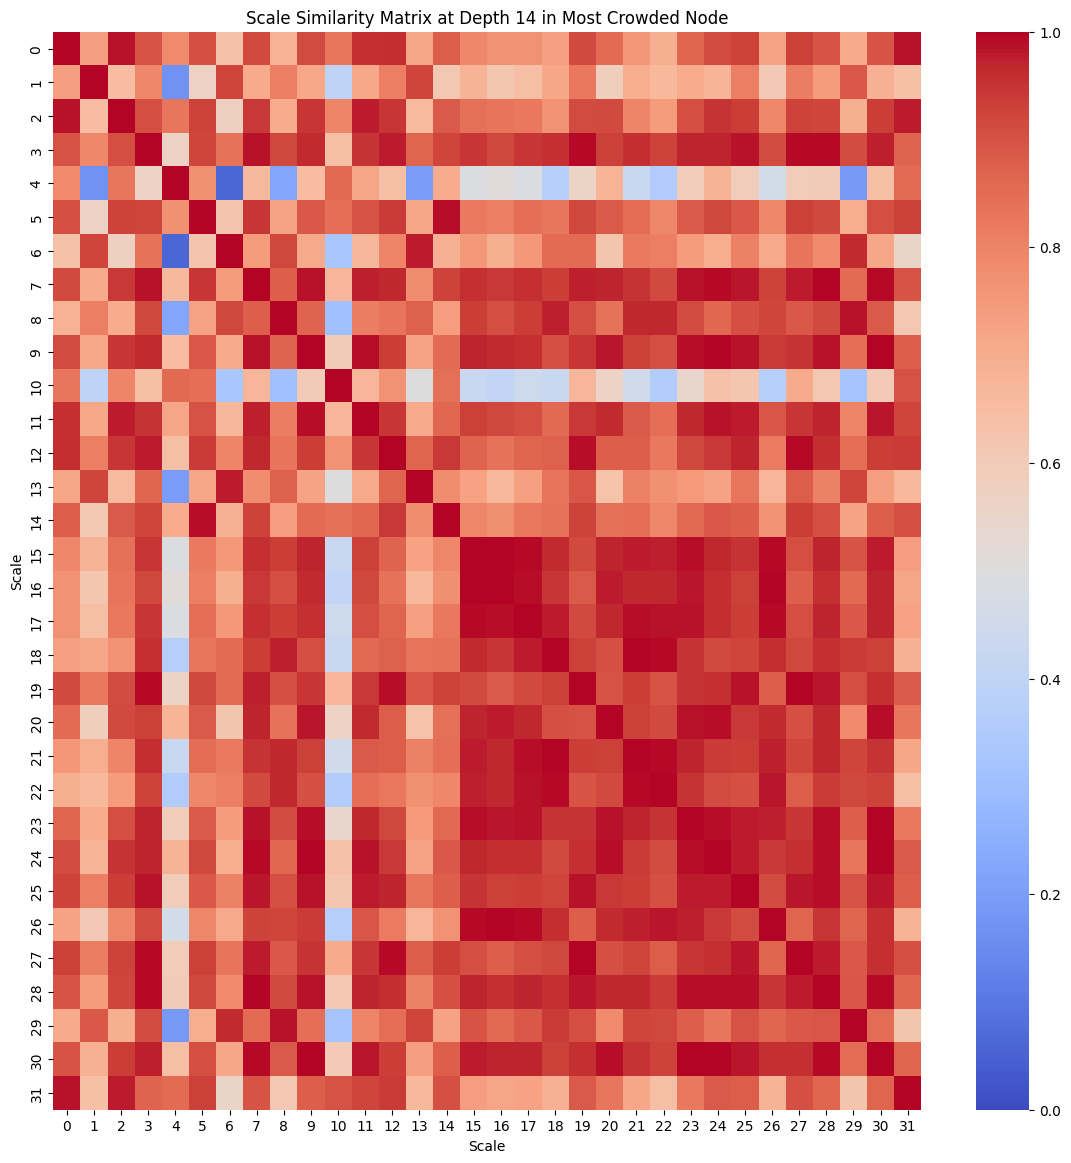

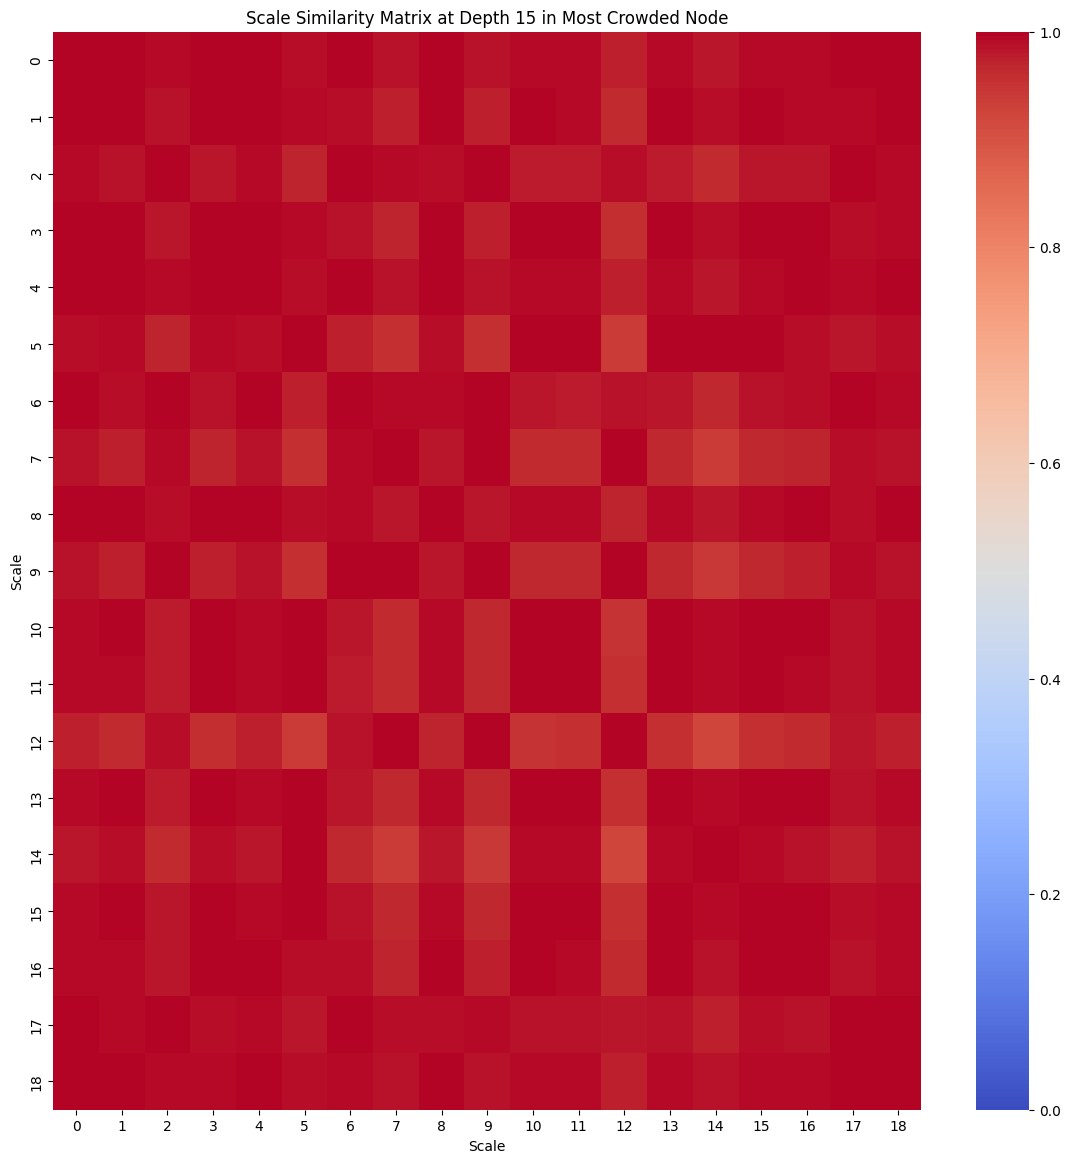

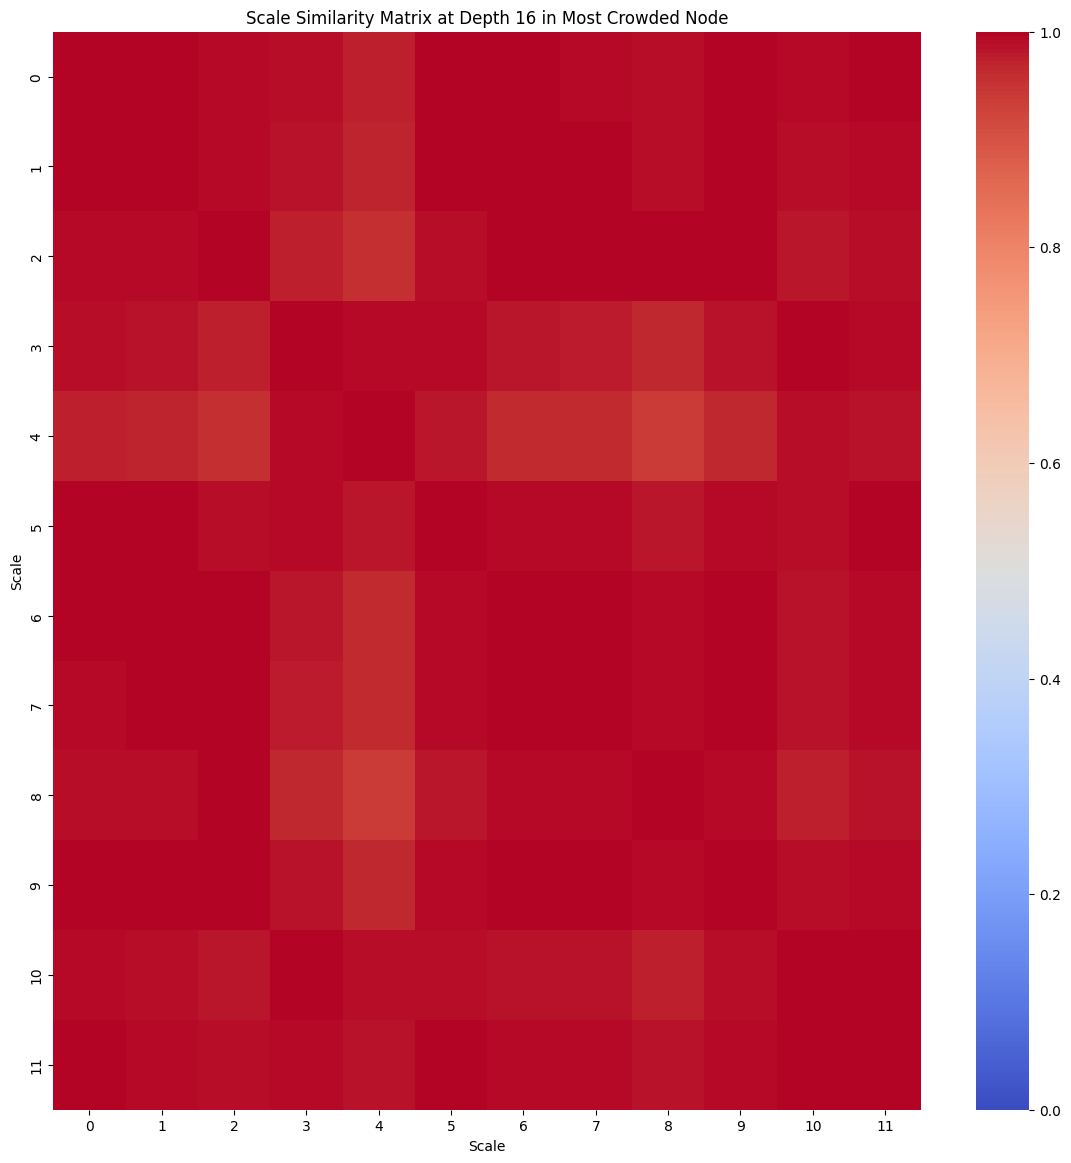

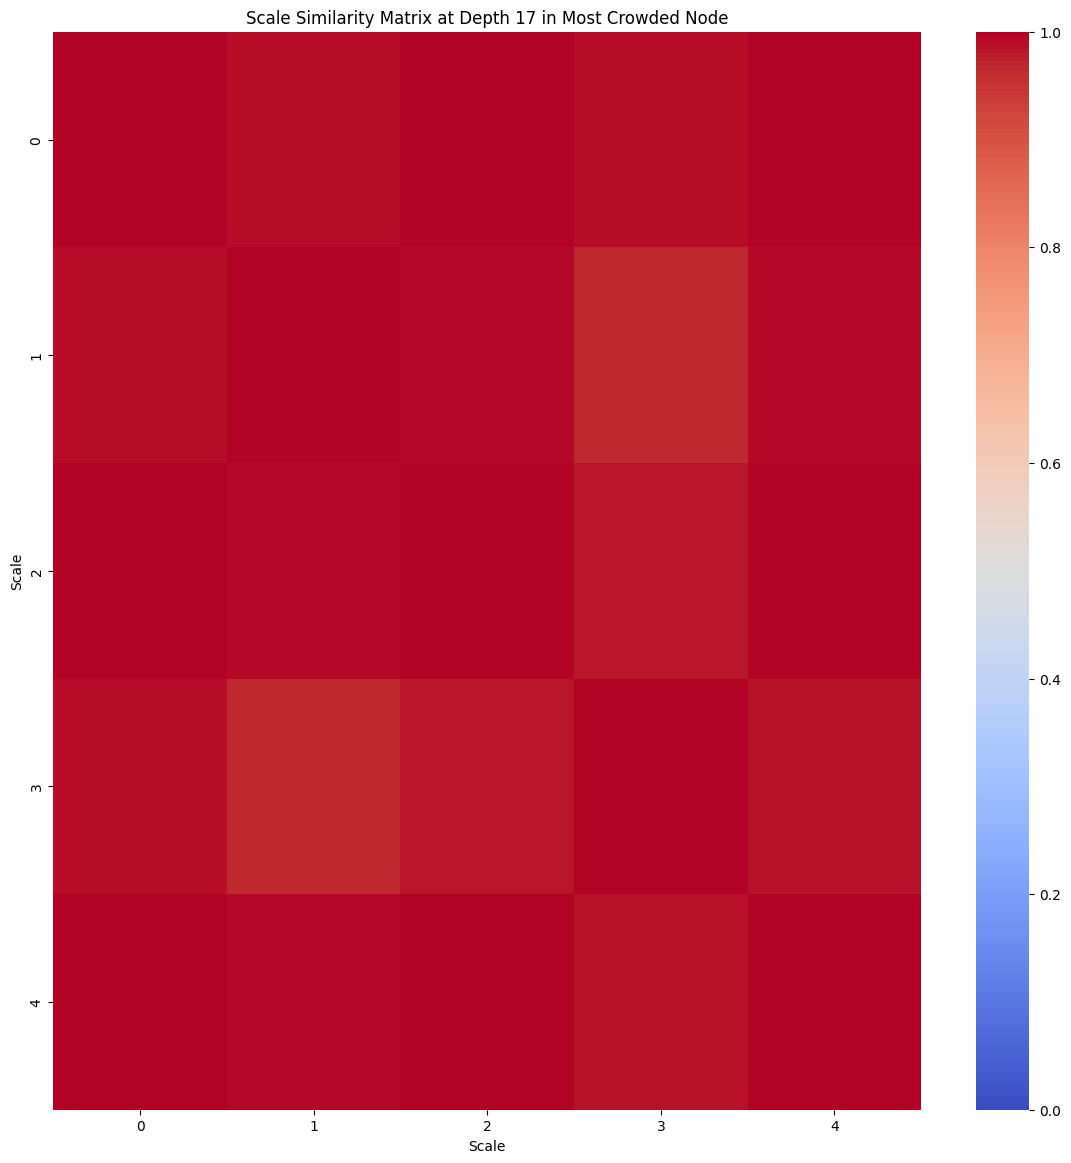

In [26]:
import seaborn as sns


for depth in range(10, 18):
    uniques, counts = unique_per_col_gaussian_node_assignments[:, depth].unique(return_counts=True)

    sorted_count, idxs = torch.sort(counts, descending=True)
    max_id = uniques[idxs[0]]

    quaternions = gaussians.get_rotation[unique_per_col_gaussian_node_assignments[:, depth] == max_id]
    compression_target = quaternions
    # scales = normalize_scales(gaussians.get_scaling[unique_per_col_gaussian_node_assignments[:, depth] == max_id])
    # compression_target = scales
    # shs = concat_spherical_harmonics(
    #     gaussians._features_dc[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
    #     gaussians._features_rest[unique_per_col_gaussian_node_assignments[:, depth] == max_id],
    #     permute=False
    # )
    # compression_target = normalize_scales(shs)

    # Compare each quaternion with every other quaternion
    N = compression_target.shape[0]
    similarity_matrix = torch.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            # similarity_matrix[i, j] = distance_to_similarity(
            #     l2_similarity(
            #         compression_target[i], compression_target[j])
            # ).detach().cpu()
            similarity_matrix[i, j] = cosine_similarity(
                    compression_target[i], compression_target[j]).detach().cpu()
            similarity_matrix[j, i] = similarity_matrix[i, j]

    # Define a similarity threshold
    threshold = 0.95
    similarity_matrix_bool = similarity_matrix >= threshold

    # Visualization
    plt.figure(figsize=(14, 14))
    sns.heatmap(
        similarity_matrix.numpy(), annot=False, cmap='coolwarm', cbar=True, 
        vmin=0, vmax=1,  # Fixed color map range
        # xticklabels=[f'Q{i+1}' for i in range(N)], 
        # yticklabels=[f'Q{i+1}' for i in range(N)]
    )
    plt.title(f'Scale Similarity Matrix at Depth {depth} in Most Crowded Node')
    plt.xlabel('Scale')
    plt.ylabel('Scale')
    plt.show()

In [84]:
unique_per_col_gaussian_node_assignments[unique_per_col_gaussian_node_assignments[:, depth] == 0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

In [85]:
unique_per_col_gaussian_node_assignments[unique_per_col_gaussian_node_assignments[:, depth-1] == 0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

## Serialization (takes forever)

In [76]:
gaussian_level_bboxes

tensor([[6, 7, 3,  ..., 1, 5, 2],
        [6, 7, 3,  ..., 6, 5, 4],
        [6, 7, 2,  ..., 4, 7, 5],
        ...,
        [6, 3, 4,  ..., 5, 1, 2],
        [6, 7, 6,  ..., 0, 7, 7],
        [2, 5, 6,  ..., 5, 4, 2]], device='cuda:0', dtype=torch.int8)

In [100]:
# Define a function to convert each row into a unique identifier
def tensor_to_identifier(t):
    # Ensure the tensor is of the right shape (N, 5)
    t_flat = t.view(t.size(0), -1).long()
    # Use powers of 10 to create unique identifiers
    base = 8
    identifiers = torch.zeros(t_flat.size(0), dtype=torch.long).to("cuda")
    for i in range(t_flat.size(1)):
        identifiers += t_flat[:, i] * (base ** (t_flat.size(1) - 1 - i))
    return identifiers

In [156]:
def compute_correlation_matrix(t):
    # Ensure the tensor is of shape (N, M)
    if t.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional")
    
    # Center the data by subtracting the mean
    t_centered = t - t.mean(dim=0)
    
    # Compute the covariance matrix
    covariance_matrix = torch.mm(t_centered.t(), t_centered) / (t.size(0) - 1)
    
    # Compute the standard deviations
    std_dev = t.std(dim=0)
    
    # Compute the correlation matrix
    correlation_matrix = covariance_matrix / torch.ger(std_dev, std_dev)
    
    return correlation_matrix

def compute_r_squared(target, predictor):
    target_mean = torch.mean(target)
    ss_total = torch.sum((target - target_mean) ** 2)
    ss_residual = torch.sum((target - predictor) ** 2)
    
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [174]:
asked2 = gaussian_node_assignments[:, 14]
uniques, counts = asked2.unique(return_counts=True)
max_idx = torch.argmax(counts)

most_frequent_bbox_for_depth2 = uniques[max_idx]

# The bin with highest number of counts
mask2 = (asked2 == most_frequent_bbox_for_depth2)

print(mask2.sum())

gaussian_node_assignments[mask2, 19]

tensor(26, device='cuda:0')


tensor([995645775337376725, 995645775337375713, 995645775337374714,
        995645775337380866, 995645775337380868, 995645775337381036,
        995645775337379970, 995645775337375559, 995645775337380996,
        995645775337380886, 995645775337375740, 995645775337388070,
        995645775337380864, 995645775337383711, 995645775337375557,
        995645775337374546, 995645775337380869, 995645775337374531,
        995645775337375722, 995645775337374684, 995645775337380864,
        995645775337374662, 995645775337374663, 995645775337380886,
        995645775337375556, 995645775337374528], device='cuda:0')

In [197]:
end_string = ""
for j in range(10):
    print(j)
    unique_ids = gaussian_node_assignments[:, j].unique().sort()[0]

    for i in range(unique_ids.shape[0]):
        bitstring = torch.zeros((8), dtype=torch.long).cuda()
        mask = (gaussian_node_assignments[:, j] == unique_ids[i])
        
        octants = gaussian_level_bboxes[mask, j+1].unique().long()
        bitstring[octants] = 1

        end_string += bitstring.cpu().numpy().astype(str).tolist().__str__()

        # print(len(end_string))

print(end_string)


0
1
2
3
4
5
6
7
8
9


: 

In [184]:
asked = gaussian_level_bboxes[:, :15]

result = tensor_to_identifier(asked)

uniques, counts = result.unique(return_counts=True)
max_idx = torch.argmax(counts)

# The bin with highest number of counts
most_frequent_bbox_for_depth = uniques[max_idx]

mask = (result == most_frequent_bbox_for_depth)


# print(gaussians.get_scaling[mask])
# print(gaussians.get_opacity[mask])
# print(gaussians.get_features[mask])

mean_samples = torch.mean(gaussians.get_scaling[mask], dim=0)
target_sample = gaussians.get_scaling[mask][0]

r_squared = compute_r_squared(target_sample, mean_samples)

# print(r_squared)

tensor([[6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 7, 4, 0, 4, 6]],
       device='cuda:0', dtype=torch.int8)
tensor([[6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 6, 3, 4, 3, 7]],
       device='cuda:0', dtype=torch.int8)
tensor([[6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 0, 2],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 0, 4],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 2, 5, 4],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 4, 2, 0, 2],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 2, 0, 4],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 2, 6],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 0, 0],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 0, 5],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 0, 0],
        [6, 7, 2, 1, 1, 7, 5, 0, 7, 2, 7, 1, 0, 6, 4, 5, 6, 0, 2, 6]],
       device='cuda:0', dtype=torch.int8)
tensor([[6, 7, 2, 1, 1, 7, 5, 0